In [ ]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from pymongo import MongoClient
import numpy as np
from ndlibCustom.SEIR_ASModel import SEIR_ASModel
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import scipy.stats as st
from IPython.display import clear_output

In [2]:
import src.dataset_generators.sezioni_generator
import src.dataset_generators.schools_generator
import src.layer_generators.household_layer
import src.layer_generators.school_layer
import src.layer_generators.work_layer
import src.graph_generators.graph_generator_full

client = MongoClient('localhost', 27017)

In [3]:
def getWorkersDist():
    client = MongoClient('localhost', 27017)
    db = client['tesi']
    db_sezioni = db['sezioni']
    db_lavoro = db['lavoro']

    work_dist = {}
    #work_dist = []
    for i in list(db_sezioni.find()):
        #print("Indexing sez:",i["properties"]["SEZ"], end="\r", flush=True)
        num_attivi = 0
        num_workers = 0
        if "famiglie" in i.keys():
            for fam in i["famiglie"]:
                for mem in fam["members"]:
                    if mem["age"] == "20-64": 
                        num_attivi += 1
                        if "sez_lavoro" in mem.keys(): num_workers += 1
            if (num_workers != 0 and num_attivi != 0):
                work_dist[i["properties"]["SEZ"]] = (num_workers/num_attivi)*100
                #work_dist.append({"sez":i["properties"]["SEZ"],"num":(num_workers/num_attivi)*100})

    return work_dist
    #list_dist =  [i["num"] for i in work_dist]
    #print("Mean percentual of workers for sez:",np.mean(list_dist))
    #return list_dist

def getAgeDistrib(defgraph,gc):
    agedistrib_g1 = []
    a1 = 0
    a2 = 0
    a3 = 0
    for i in defgraph.nodes():
        if defgraph.nodes[i]['age'] == '65+':
            a3 += 1
        elif defgraph.nodes[i]['age'] == '20-64':
            a2 += 1
        else: 
            a1 +=1
    print("Distribuzione di età su grafo totale")
    print("Giovani:",a1,"Attivi:",a2,"Anziani:",a3)
    print()
    g1 = a1
    g2 = a2
    g3 = a3
    for i in gc.nodes():
        if gc.nodes[i]['age'] == '65+':
            a3 -= 1
        elif gc.nodes[i]['age'] == '20-64':
            a2 -= 1
        else: 
            a1 -=1
    return [a1,a2,a3,g1,g2,g3]
    #print("Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)")
    #print("Giovani:",a1,"(",round((a1/g1)*100,3),")","Attivi:",a2,"(",round((a2/g2)*100,3),")","Anziani:",a3,"(",round((a3/g3)*100,3),")")
    #print()
    #print("Nodi appartenenti alla Giant Component")
    #print("Giovani:",g1-a1,"Attivi:",g2-a2,"Anziani:",g3-a3)
    
def getLastIterationStatusesByAge(simdata, defgraph):
    iteration = simdata
    graph_stat = {}
    
    for x in iteration[0]['status']:
        graph_stat[x] = iteration[0]['status'][x]
    for iter in iteration:
        for s in iter['status']:
            graph_stat[s] = iter['status'][s]    

    stats_giovani = {0:[],1:[],2:[],3:[],4:[],5:[]}
    stats_attivi = {0:[],1:[],2:[],3:[],4:[],5:[]}
    stats_anziani = {0:[],1:[],2:[],3:[],4:[],5:[]}
    
    for i in graph_stat:
        if defgraph.nodes[i]['age'] == '65+':
            stats_anziani[graph_stat[i]].append(i)
        elif defgraph.nodes[i]['age'] == '20-64':
            stats_attivi[graph_stat[i]].append(i)
        else:
            stats_giovani[graph_stat[i]].append(i)
    
    return {'giovani':stats_giovani,'attivi':stats_attivi,'anziani':stats_anziani}

def getNeighborhoodGC(simdata, GC, defgraph):
    iteration = simdata
    nodelist = []
    neighbors = {}
    graph_stat = {}
    neighbors_s = {}
    neighbors_r = {}
                     
    #Rebuild current iteration status tree
    for x in iteration[0]['status']:
        graph_stat[x] = iteration[0]['status'][x]
    for iter in iteration:
        for s in iter['status']:
            graph_stat[s] = iter['status'][s]   
   
    #Cycle through nodes
    for i in GC.nodes():
        if i in graph_stat.keys():
            #Process selected S_Nodes
            if graph_stat[i] == 0:
                nodelist.append(i)
                neighborhood = [n for n in defgraph.neighbors(i)]
                neighbors_s[i] = []
                neighbors_r[i] = []
                sum = 0
                sus = 0
                rem = 0
                for n in neighborhood:
                    neighbors[n] = graph_stat[n]
                    sum += 1
                    if graph_stat[n] == 0: sus += 1
                    if graph_stat[n] == 5: rem += 1
                neighbors_s[i].append(int((sus/sum)*100))
                neighbors_r[i].append(int((rem/sum)*100))
    return {'nodelist':nodelist,'neighbors':neighbors,'s':neighbors_s,'r':neighbors_r}

def buildSimulationProgressionByAge(simdata, defgraph):
    graph_stat = {}
    giovani_a = {}
    giovani_s = {}
    attivi_a = {}
    attivi_s = {}
    anziani_a = {}
    anziani_s = {}

    #Build graph_stat with starting statuses
    for i in simdata[0]['status']:
        graph_stat[i] = simdata[0]['status'][i]

    #Rebuild simulations by age and status evolution
    for iter in simdata:
        inc_1a = 0
        inc_1s = 0
        inc_2a = 0
        inc_2s = 0
        inc_3a = 0
        inc_3s = 0
        for s in iter['status']:
            if graph_stat[s] == 0 or graph_stat[s] == 1 or graph_stat[s] == 2:
                if iter['status'][s] == 3:
                    if defgraph.nodes[s]['age'] == '20-64':
                        inc_2a += 1
                    elif defgraph.nodes[s]['age'] == '65+':
                        inc_3a += 1
                    else: 
                        inc_1a += 1
                elif iter['status'][s] == 4:
                    if defgraph.nodes[s]['age'] == '20-64':
                        inc_2s += 1
                    elif defgraph.nodes[s]['age'] == '65+':
                        inc_3s += 1
                    else: 
                        inc_1s += 1
        #Append data of current n-iteration
        giovani_a[iter['iteration']] = inc_1a
        giovani_s[iter['iteration']] = inc_1s
        attivi_a[iter['iteration']] = inc_2a
        attivi_s[iter['iteration']] = inc_2s
        anziani_a[iter['iteration']] = inc_3a
        anziani_s[iter['iteration']] = inc_3s
    return {'giovani_a':giovani_a,'giovani_s':giovani_s,'attivi_a':attivi_a,'attivi_s':attivi_s,'anziani_a':anziani_a,'anziani_s':anziani_s}

def buildHeatmap(simdata,defgraph,pop):
    db = client['tesi']
    db_sezioni = db['sezioni']
    iteration = simdata
    graph_stat = {}

    #Rebuild current iteration status tree
    for x in iteration[0]['status']:
        graph_stat[x] = iteration[0]['status'][x]
    for iter in iteration:
        for s in iter['status']:
            graph_stat[s] = iter['status'][s] 
            
    heatmap_r = {}
    heatmap_s = {}
    for i in list(db_sezioni.find()):
        heatmap_s[i["properties"]["SEZ"]] = 0
        heatmap_r[i["properties"]["SEZ"]] = 0

    for i in graph_stat:
        if graph_stat[i] == 0:
            heatmap_s[defgraph.nodes[i]['sez']] += 1
        elif graph_stat[i] == 5:
            heatmap_r[defgraph.nodes[i]['sez']] += 1

    for i in heatmap_s:
        try:
            if pop[i] > 0:
                heatmap_s[i] = (heatmap_s[i]/pop[i])*100
        except:
            continue
            
    for i in heatmap_r:
        try:
            if pop[i] > 0:
                heatmap_r[i] = (heatmap_r[i]/pop[i])*100
        except:
            continue

    return {'s':heatmap_s, 'r':heatmap_r}

In [ ]:
%%capture cap
#CUSTOM SEIR_AS MODEL SIMULATION
print("Simulating...")
#Run 50 simulations, results will be a mean of all data generated
simulations = []

it = 0
while it < 50:
    print("Running simulation number",it+1)
    #Create dist containing all simulation information
    sim = {}
    tot_agedistrib = {"giovani":[],"attivi":[],"anziani":[]}
    G0_agedistrib = {"giovani":[],"attivi":[],"anziani":[]}

    #Clear last iteration's graph DB
    try:
        client.drop_database('tesi')
        print("Database cleared.")
    except:
        print("There is no database currently saved.")

    #Generate new multilayer graph
    src.dataset_generators.sezioni_generator.main()
    src.dataset_generators.schools_generator.main()
    try:
        families_distance, sez_pop = src.layer_generators.household_layer.main()
    except:
        print("Household layer failed to generate. Restarting iteration...")
        continue
    src.layer_generators.school_layer.main()
    src.layer_generators.work_layer.main()
    graph = src.graph_generators.graph_generator_full.main() 
        
    # Model selection
    model = SEIR_ASModel(graph)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
    cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
    cfg.add_model_parameter('alpha', 0.2) #Latent period
    cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

    #This parameter "smoothens" out the infection rate in the first iterations.
    #1: 1-(1-beta)^(num_of_infected_neighbors)[0.99 on > 5 infected neighbors]
    #0: beta*(average_infected_weight)
    cfg.add_model_parameter('tp_rate', 0)

    #Activate school layer
    cfg.add_model_parameter('schools', 1)

    cfg.add_model_parameter("fraction_infected", 0.005) #Starting infected nodes
    model.set_initial_status(cfg)
        
    #Save graph related files
    sim['workers_dist'] = getWorkersDist()
    sim['families_distance'] = families_distance
    sim['density'] = nx.density(graph)
    sim['degree'] = graph.degree()
    sim['edges'] = len(graph.edges())
    sim['nodes'] = len(graph.nodes())
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    temp = getAgeDistrib(graph,graph.subgraph(Gcc[0]))
    
    # THIS SECTION HAS AN ISSUE! WE KEEP IT LIKE THIS SO THAT THE REST OF THE CODE DOESNT NEED TO BE CHANGED.
    # ISSUES ARE COMMENTED
    tot_agedistrib['giovani'].append(temp[0])
    tot_agedistrib['attivi'].append(temp[1])
    tot_agedistrib['anziani'].append(temp[2])
    G0_agedistrib['giovani'].append(temp[3])
    G0_agedistrib['attivi'].append(temp[4])
    G0_agedistrib['anziani'].append(temp[5])
    sim['tot_agedistrib'] = tot_agedistrib #Tot is actually the nodes outside of G0. 
    sim['G0_agedistrib'] = G0_agedistrib #G0 is actually the total of nodes. 
    
    #RUN ITERATION WITH SCHOOL LAYER
    lastsim = model.iteration_bunch(60,progress_bar=True)
    for i in lastsim:
        i.pop('node_count')
        i.pop('status_delta')

    #Save iteration related data
    sim['simulation'] = lastsim
    sim['last_iteration_status'] = getLastIterationStatusesByAge(lastsim,graph)
    sim['herd_immunity_gc'] = getNeighborhoodGC(lastsim, graph.subgraph(Gcc[0]), graph)
    sim['progression'] = buildSimulationProgressionByAge(lastsim,graph)
    sim['heatmap'] = buildHeatmap(lastsim,graph,sez_pop)
    
    #RUN ITERATION WITHOUT SCHOOL LAYER
    # Model Configuration
    model.reset()
    cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
    cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
    cfg.add_model_parameter('alpha', 0.2) #Latent period
    cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

    #This parameter "smoothens" out the infection rate in the first iterations.
    #1: 1-(1-beta)^(num_of_infected_neighbors)[0.99 on > 5 infected neighbors]
    #0: beta*(average_infected_weight)
    cfg.add_model_parameter('tp_rate', 0)

    #Activate school layer
    cfg.add_model_parameter('schools', 0)

    cfg.add_model_parameter("fraction_infected", 0.005) #Starting infected nodes
    model.set_initial_status(cfg)
    
    lastsim = model.iteration_bunch(60,progress_bar=True)
    for i in lastsim:
        i.pop('node_count')
        i.pop('status_delta')

        #Save iteration related data
    sim['noschool_simulation'] = lastsim
    sim['noschool_last_iteration_status'] = getLastIterationStatusesByAge(lastsim,graph)
    sim['noschool_herd_immunity_gc'] = getNeighborhoodGC(lastsim, graph.subgraph(Gcc[0]), graph)
    sim['noschool_progression'] = buildSimulationProgressionByAge(lastsim,graph)
    sim['noschool_heatmap'] = buildHeatmap(lastsim,graph,sez_pop)

    simulations.append(sim)
    del(graph) #Remove graph and reclaim memory for next iteration
    #clear_output() #Clear output to avoid cluttering: simulation number will be printed at each iteration
    it += 1

In [81]:
print(lastsim[0].keys())
#cap.show()
with open('output.txt', 'w') as f:
    f.write(cap.stdout)
print(len(simulations))
print(simulations[0].keys())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|##########| 60/60 [13:04<00:00, 13.07s/it]


50
dict_keys(['workers_dist', 'families_distance', 'density', 'degree', 'tot_agedistrib', 'G0_agedistrib', 'simulation', 'last_iteration_status', 'herd_immunity_gc', 'progression', 'heatmap', 'noschool_simulation', 'noschool_last_iteration_status', 'noschool_herd_immunity_gc', 'noschool_progression', 'noschool_heatmap'])


In [107]:
#GENERATE DATA FOR NODES AND EDGES
a_file = open("output.txt")

nodes = []
edges = []
lines = a_file.readlines()
for line in lines:
    line = line.split()
    try:
        if line[0] == "total":
            if line[1] == "nodes:":
                nodes.append(int(line[2]))
            elif line[1] == "edges:":
                edges.append(int(line[2]))
    except:
        pass

print("Mean nodes:",np.mean(nodes))
print("CI 95%:",st.t.interval(alpha=0.95, df=len(nodes)-1, loc=np.mean(nodes), scale=st.sem(nodes)))
print()
print("Mean edges:",np.mean(edges))
print("CI 95%:",st.t.interval(alpha=0.95, df=len(edges)-1, loc=np.mean(edges), scale=st.sem(edges)))
print()

Mean nodes: 1230042.74
CI 95%: (1229985.9086389614, 1230099.5713610386)

Mean edges: 9042323.22
CI 95%: (9039719.329267612, 9044927.11073239)



In [546]:
%matplotlib inline
mean_degree = {}
for i in range(0,max(len(sim['degree']) for sim in simulations)):
    mean_degree[i] = []
    
for sim in simulations:
    for node in dict(sim['degree']).keys():
        mean_degree[node].append(sim['degree'][node])

for i in mean_degree.keys():
    mean_degree[i] = np.mean(mean_degree[i])
    
#Print mean density
print("Mean density")
print(np.mean([sim['density'] for sim in simulations]))
print("CI 95%:",st.t.interval(alpha=0.95, df=len([sim['density'] for sim in simulations])-1, loc=np.mean([sim['density'] for sim in simulations]), scale=st.sem([sim['density'] for sim in simulations])))
print()

#Print mean degree
print("Mean degree")
print(np.mean(list(mean_degree.values())))
print("CI 95%:",st.t.interval(alpha=0.95, df=len(list(mean_degree.values()))-1, loc=np.mean(list(mean_degree.values())), scale=st.sem(list(mean_degree.values()))))
print()

Mean density
1.1952808490323145e-05
CI 95%: (1.194954137076125e-05, 1.195607560988504e-05)

Mean degree
14.70302469695812
CI 95%: (14.688673528111932, 14.717375865804309)



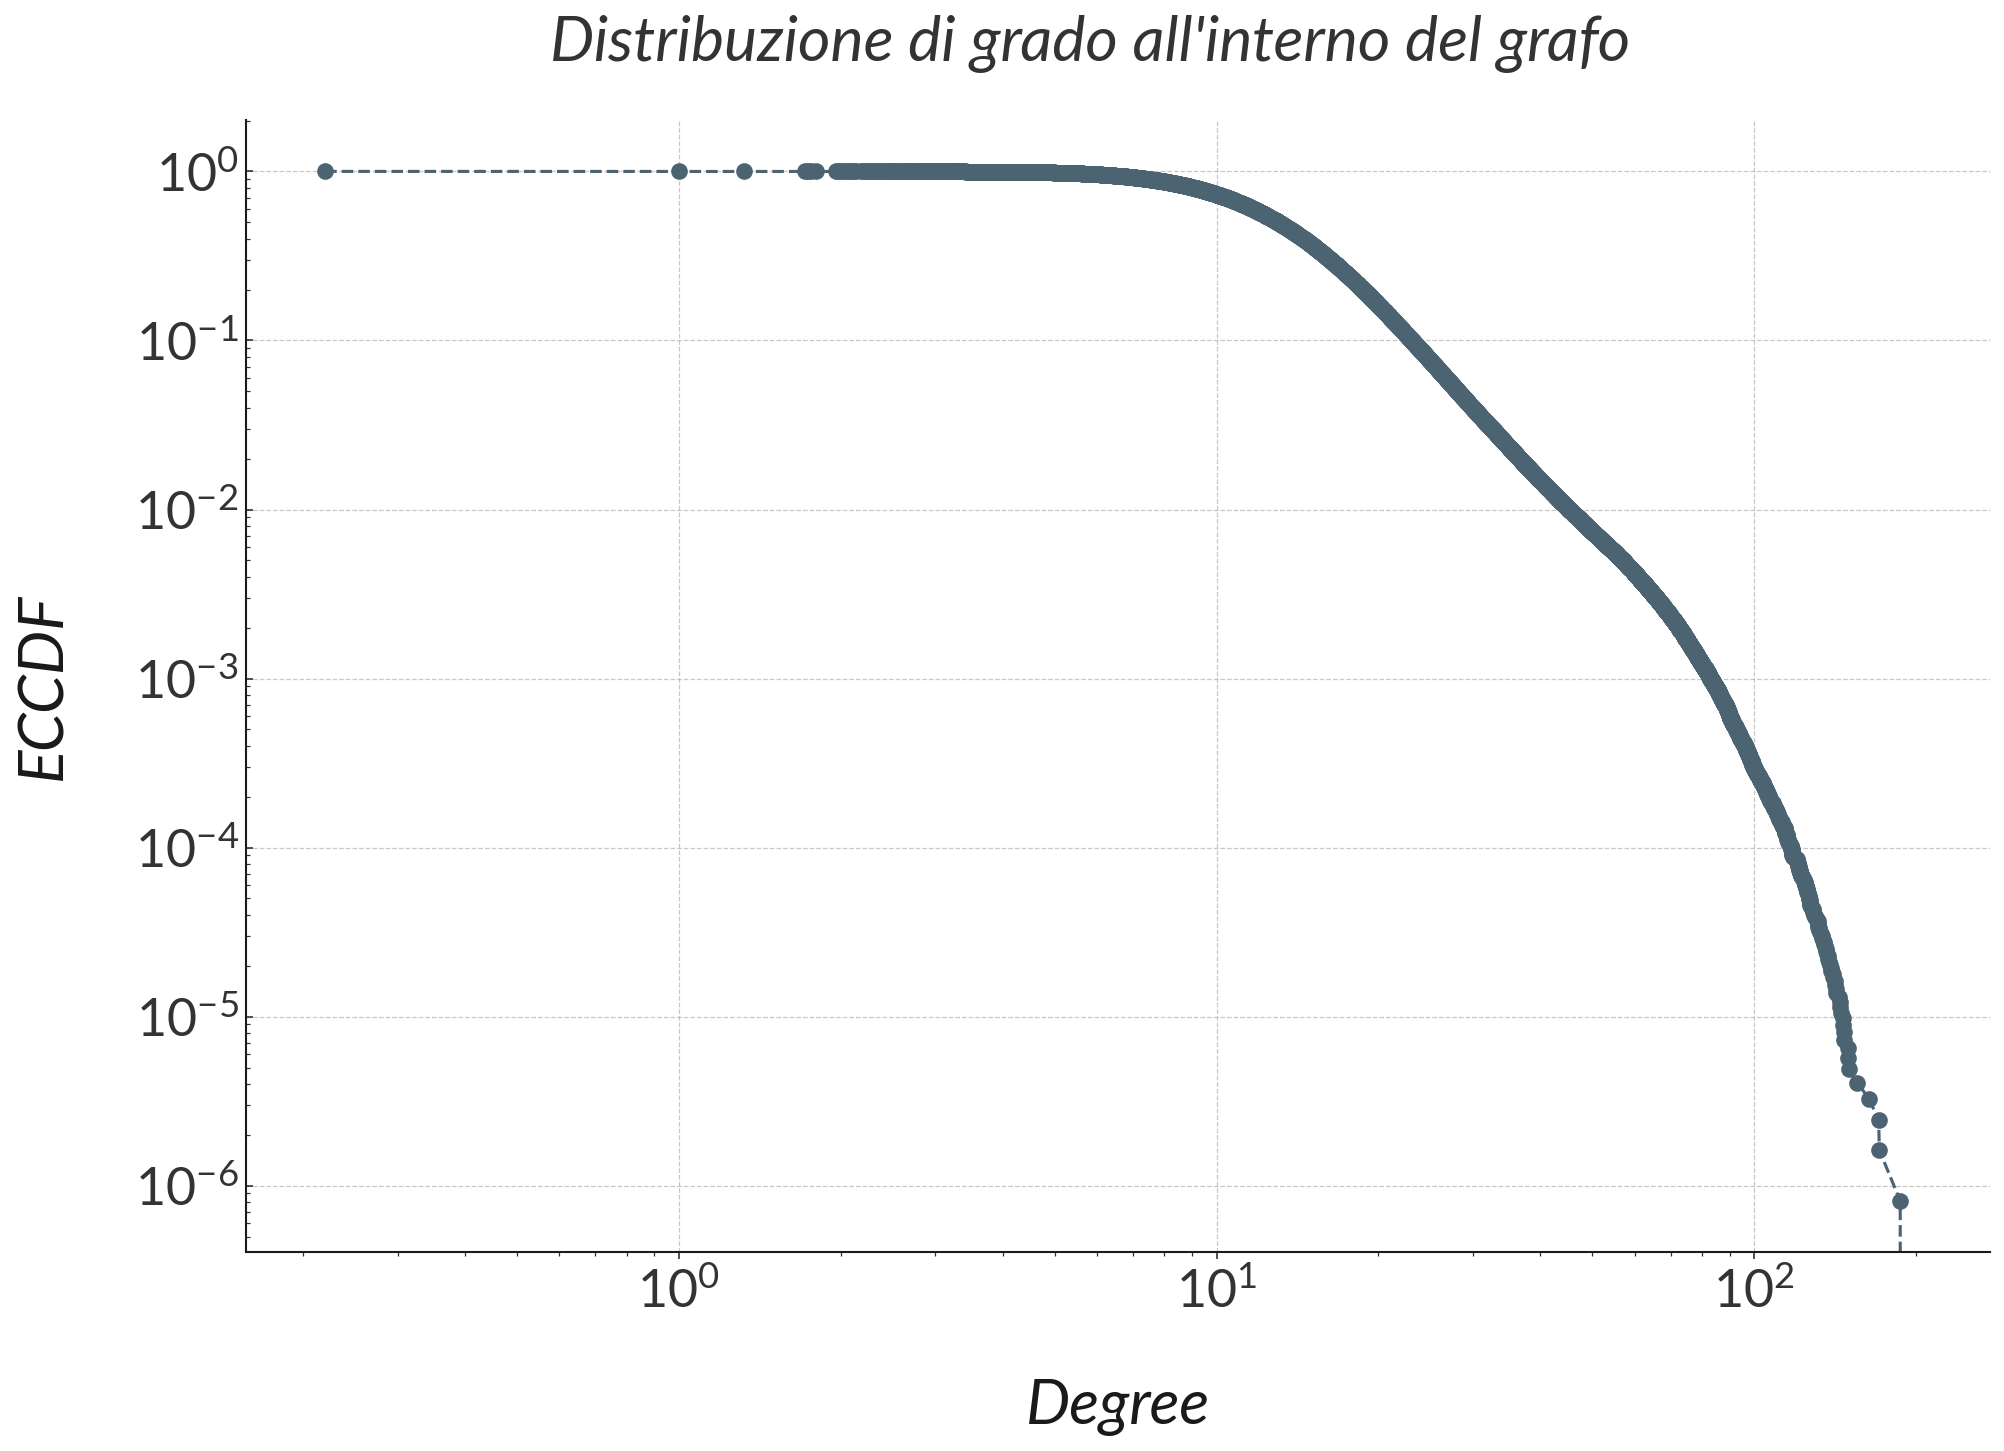

In [825]:
#ECCDF for degree data in loglog scale
plt.style.use('style.mplstyle')
cdf = ECDF(list(mean_degree.values()))
x = np.unique(list(mean_degree.values()))
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
plt.suptitle('Distribuzione di grado all\'interno del grafo', style='italic', y=0.95)
axes.set_xlabel('Degree', labelpad=30, style='italic')
axes.set_ylabel('ECCDF', labelpad=30, style='italic')
plt.savefig('export_multi_full/eccdf_degree.png')

Mean percentual of workers for sez
49.599081825588804
CI 95%: (49.355504382754795, 49.842659268422814)



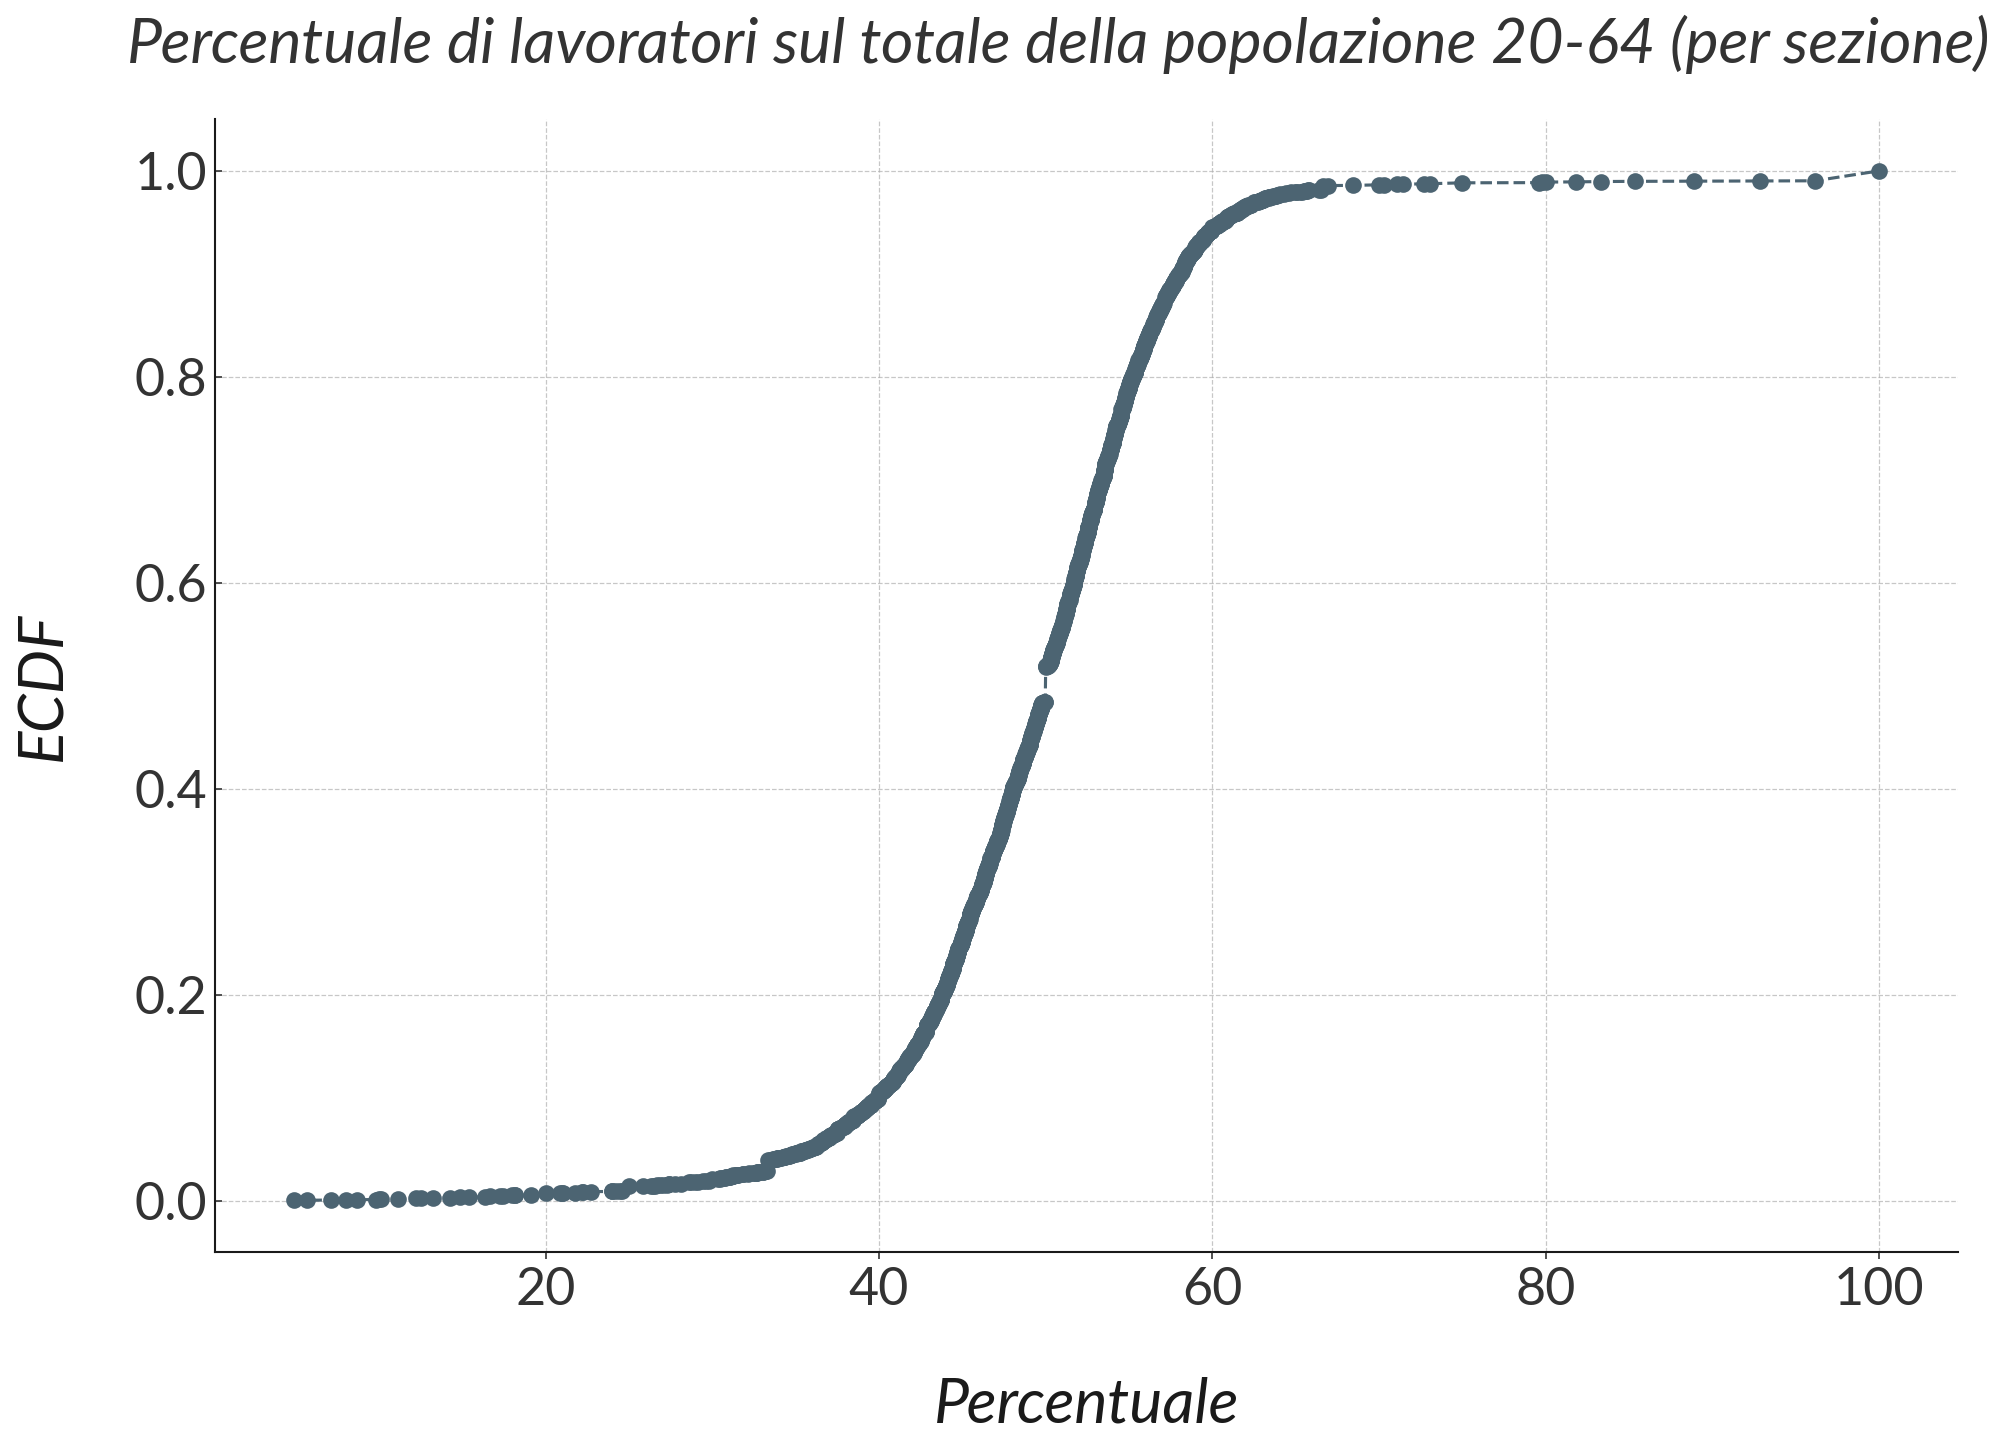

In [826]:
%matplotlib inline
plt.style.use('style.mplstyle')
mean_workers_dist = {}

for sim in simulations:
    for node in sim['workers_dist'].keys():
        mean_workers_dist[node] = []

for sim in simulations:
    for node in sim['workers_dist'].keys():
        mean_workers_dist[node].append(sim['workers_dist'][node])

for i in mean_workers_dist:
    mean_workers_dist[i] = np.mean(mean_workers_dist[i]) 

print("Mean percentual of workers for sez")
print(np.mean(list(mean_workers_dist.values())))
print("CI 95%:",st.t.interval(alpha=0.95, df=len(list(mean_workers_dist.values()))-1, loc=np.mean(list(mean_workers_dist.values())), scale=st.sem(list(mean_workers_dist.values()))))
print()

#ECDF of workers distribution per sez in linear scale
plt.style.use('style.mplstyle')
cdf = ECDF(list(mean_workers_dist.values()))
x = np.unique(list(mean_workers_dist.values()))
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=8,  linestyle='--')
# general title
plt.suptitle('Percentuale di lavoratori sul totale della popolazione 20-64 (per sezione)', style='italic', y=0.95)
axes.set_xlabel('Percentuale', labelpad=30, style='italic')
axes.set_ylabel('ECDF', labelpad=30, style='italic')
plt.savefig('export_multi_full/ecdf_workers.png')

Mean families distance for simulated sez
1.4082319935588947
CI 95%: (1.40565833292086, 1.4108056541969294)



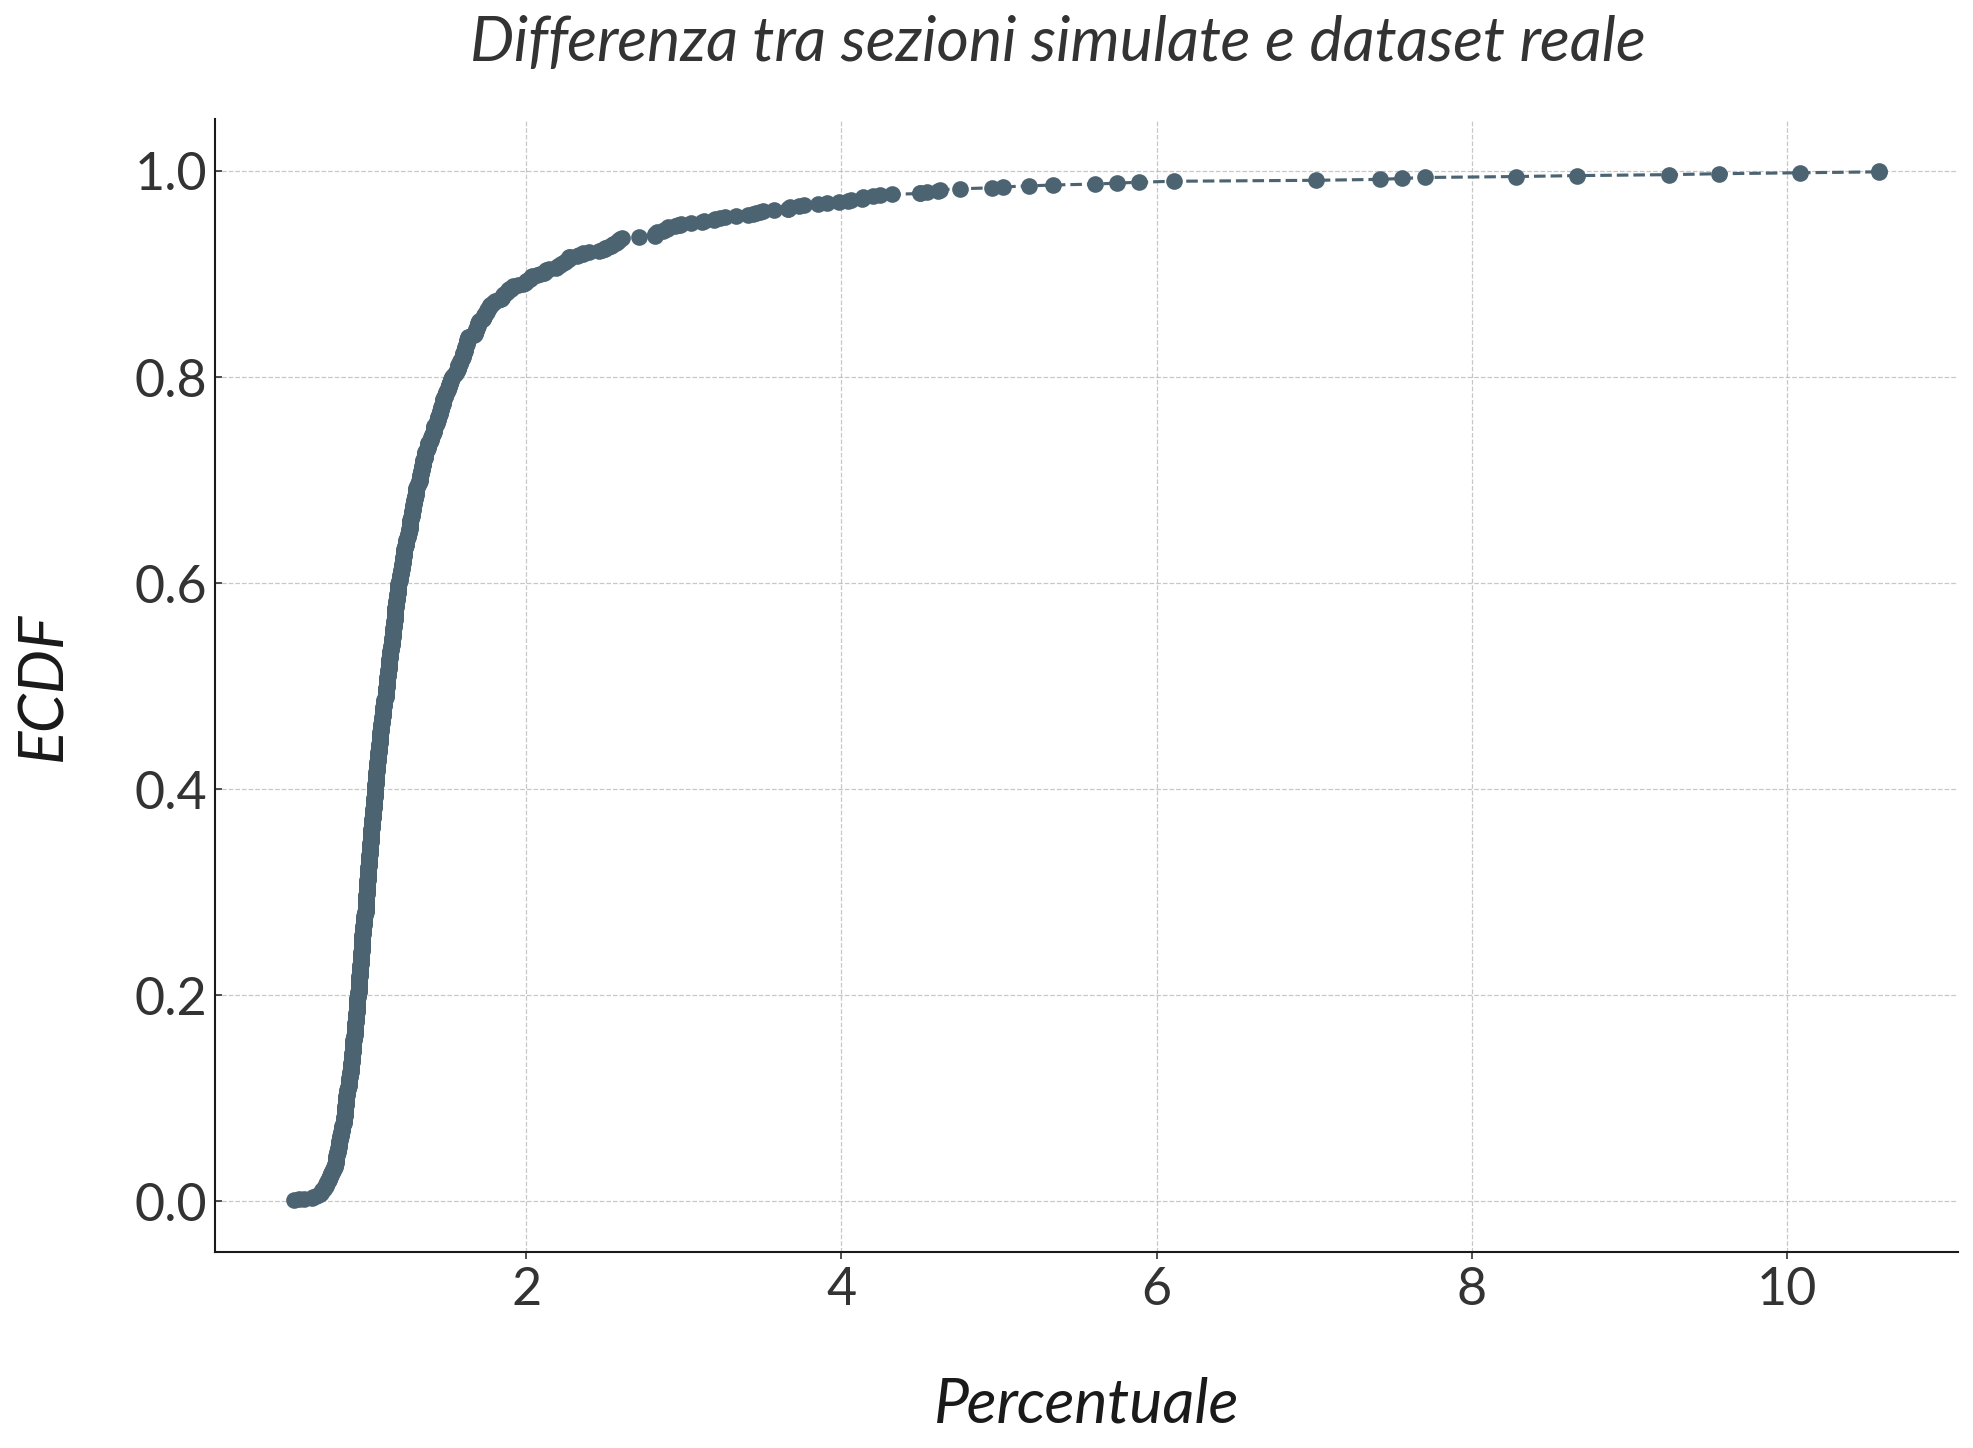

In [827]:
%matplotlib inline
#Print mean families distance
families_distance = [np.mean(list(sim['families_distance'].values())) for sim in simulations]
print("Mean families distance for simulated sez")
print(np.mean(families_distance))
print("CI 95%:",st.t.interval(alpha=0.95, df=len(families_distance)-1, loc=np.mean(families_distance), scale=st.sem(families_distance)))
print()

families_distance = {}

for sim in simulations:
    for key in sim['families_distance']:
        families_distance[key] = []

for sim in simulations:
    for key in sim['families_distance']:
        families_distance[key].append(sim['families_distance'][key])

for key in families_distance:
    families_distance[key] = np.mean(families_distance[key])

#np.mean(list(families_distance.values()))
#print(np.mean([np.mean(list(sim['families_distance'].values())) for sim in simulations]))

# ECDF linear scale
plt.style.use('style.mplstyle')
cdf = ECDF(list(families_distance.values()))
x = np.unique(list(families_distance.values()))
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=8,  linestyle='--')
#general title
plt.suptitle('Differenza tra sezioni simulate e dataset reale', style='italic', y=0.95)

axes.set_xlabel('Percentuale', labelpad=30, style='italic')
axes.set_ylabel('ECDF', labelpad=30, style='italic')
plt.savefig('export_multi_full/ecdf_families_distance.png')


Mean values
Giovani S/R [12137.82, 189306.94]
Attivi S/R [159052.12, 554963.6]
Anziani S/R [290042.46, 15253.32]

CI 95%
Giovani (S): (12076.970829858816, 12198.669170141184)
Giovani (R): (189205.14204613745, 189408.73795386255)
Attivi (S): (158766.2236678043, 159338.0163321957)
Attivi (R): (554679.9348990753, 555247.2651009246)
Anziani (S): (289991.4002187928, 290093.51978120726)
Anziani (R): (15217.33966018929, 15289.30033981071)


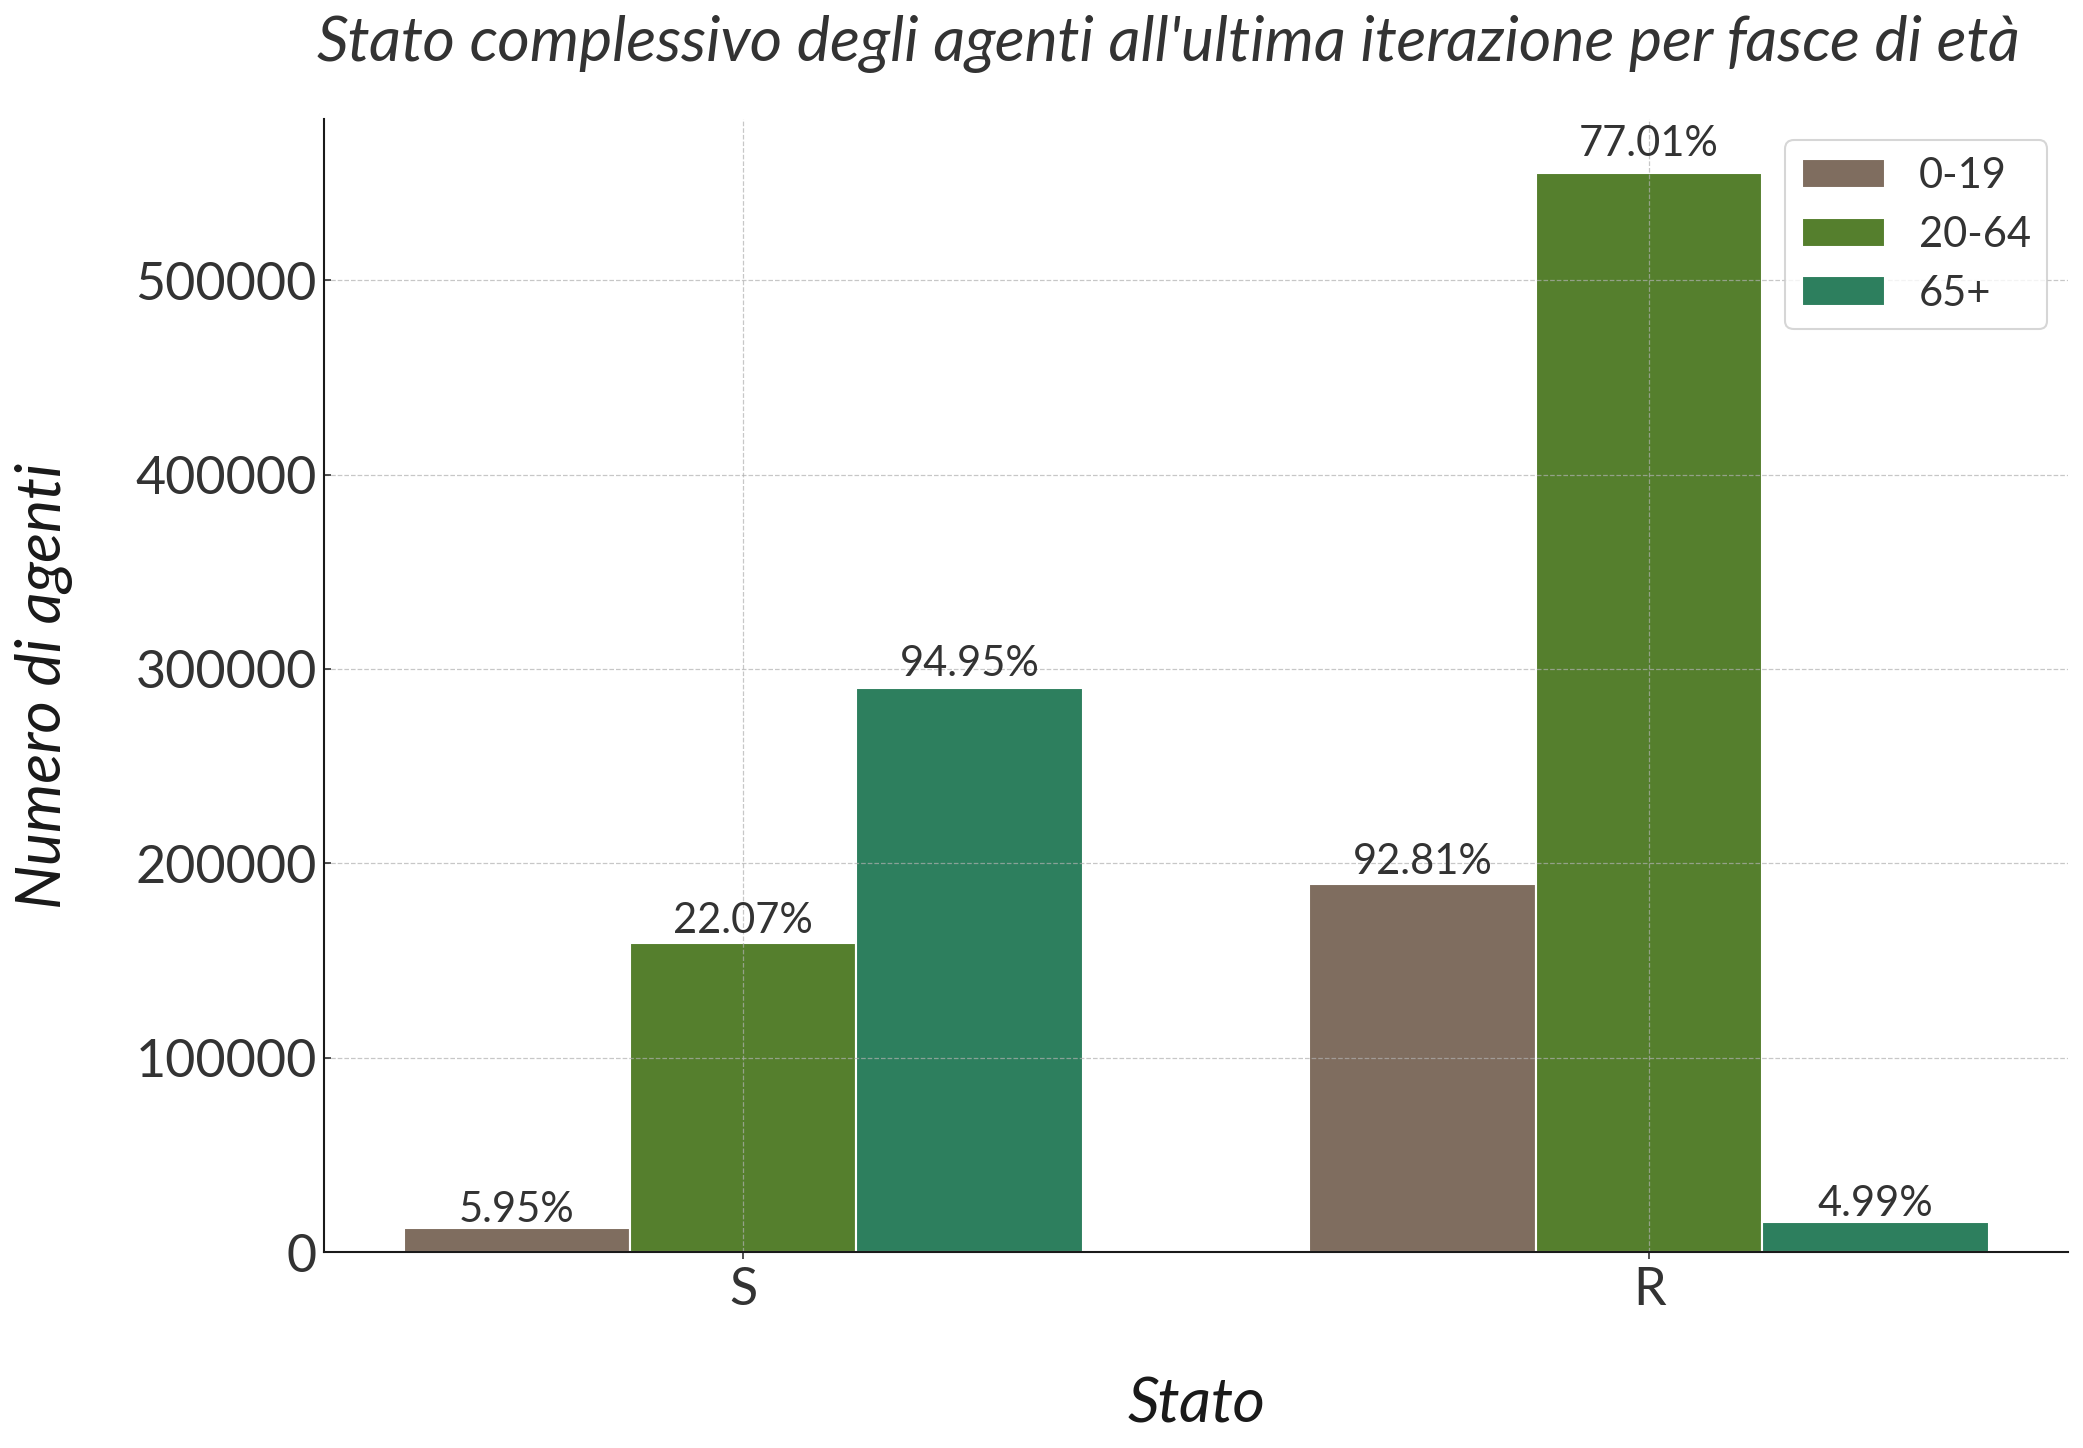

In [836]:
%matplotlib inline
#Create complete status map by dynamically rebuilding infection iteration results
#Keys are nodes, values are final statuses
#Look for keys in graph to get attributes 

##START FOR EACH                
#Calculate how many survivors in absolute at last iter
s_giovani = []
r_giovani = []
s_attivi = []
r_attivi = []
s_anziani = []
r_anziani = []

for sim in simulations:
    #Build sum of age groups 
    giovani_p = []
    attivi_p = []
    anziani_p = []
    for i in sim['last_iteration_status']['giovani']:
        giovani_p.append(len(sim['last_iteration_status']['giovani'][i]))
        attivi_p.append(len(sim['last_iteration_status']['attivi'][i]))
        anziani_p.append(len(sim['last_iteration_status']['anziani'][i]))

    #Build mean for CI(95%)
    #List "survivors" at last iteration for all simulations
    s_giovani.append(giovani_p[0])
    r_giovani.append(giovani_p[5])
    s_attivi.append(attivi_p[0])
    r_attivi.append(attivi_p[5])
    s_anziani.append(anziani_p[0])
    r_anziani.append(anziani_p[5])
##END FOR EACH

giovani_p = [np.mean(s_giovani),np.mean(r_giovani)]
attivi_p = [np.mean(s_attivi),np.mean(r_attivi)]
anziani_p = [np.mean(s_anziani),np.mean(r_anziani)]

#TODO: PLOT STATUS AT LAST ITERATION 
plt.style.use('style.mplstyle')

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(giovani_p))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
b1 = plt.bar(r1, giovani_p, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-19')
b2 = plt.bar(r2, attivi_p, color='#557f2d', width=barWidth, edgecolor='white', label='20-64')
b3 = plt.bar(r3, anziani_p, color='#2d7f5e', width=barWidth, edgecolor='white', label='65+')

def autolabel(rects,tot_pop):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.01*height, str(round((height/tot_pop)*100,2))+'%', ha='center', va='bottom', size=20)

mean_giovani = np.mean([i['G0_agedistrib']['giovani'] for i in simulations])
mean_attivi = np.mean([i['G0_agedistrib']['attivi'] for i in simulations])
mean_anziani = np.mean([i['G0_agedistrib']['anziani'] for i in simulations])

autolabel(b1, mean_giovani)
autolabel(b2, mean_attivi)
autolabel(b3, mean_anziani)

# Add xticks on the middle of the group bars
# general title
plt.suptitle("Stato complessivo degli agenti all'ultima iterazione per fasce di età", style='italic', y=0.95)
plt.xlabel("Stato", labelpad=30, style='italic')
plt.ylabel("Numero di agenti", labelpad=30, style='italic')
labels = ['S',"R"]
plt.xticks([r + barWidth for r in range(len(giovani_p))], labels)

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=20)
plt.savefig('export_multi_full/last_iteration_statuses.png')

print()
print("Mean values")
print("Giovani S/R", giovani_p)
print("Attivi S/R", attivi_p)
print("Anziani S/R", anziani_p)
print()
print("CI 95%")
print("Giovani (S):",st.t.interval(alpha=0.95, df=len(s_giovani)-1, loc=np.mean(s_giovani), scale=st.sem(s_giovani)))
print("Giovani (R):",st.t.interval(alpha=0.95, df=len(r_giovani)-1, loc=np.mean(r_giovani), scale=st.sem(r_giovani)))
print("Attivi (S):",st.t.interval(alpha=0.95, df=len(s_attivi)-1, loc=np.mean(s_attivi), scale=st.sem(s_attivi)))
print("Attivi (R):",st.t.interval(alpha=0.95, df=len(r_attivi)-1, loc=np.mean(r_attivi), scale=st.sem(r_attivi)))
print("Anziani (S):",st.t.interval(alpha=0.95, df=len(s_anziani)-1, loc=np.mean(s_anziani), scale=st.sem(s_anziani)))
print("Anziani (R):",st.t.interval(alpha=0.95, df=len(r_anziani)-1, loc=np.mean(r_anziani), scale=st.sem(r_anziani)))

    Percentuale Numero di individui S/R
0          0-10                8293   S
1          0-10                9255   R
2          0-10                8275   S
3          0-10                8406   R
4          0-10                8113   S
..          ...                 ...  ..
995      91-100                7823   R
996      91-100                7962   S
997      91-100                8041   R
998      91-100                8078   S
999      91-100                7935   R

[1000 rows x 3 columns]

Nodi in stato S all'ultima iterazione: 24247.54
CI 95% (24114.673887572422, 24380.40611242758)

Numero di neighbors dei nodi con stato S all'ultima iterazione: 32225.96
CI 95% (32070.436300291567, 32381.48369970843)

S: 16056.14 R: 15564.74 EAS/IAS: 605.08
CI 95%
S (15925.486595819819, 16186.79340418018)
R (15507.339448024717, 15622.140551975283)
EAS/IAS (590.2466731352454, 619.9133268647547)


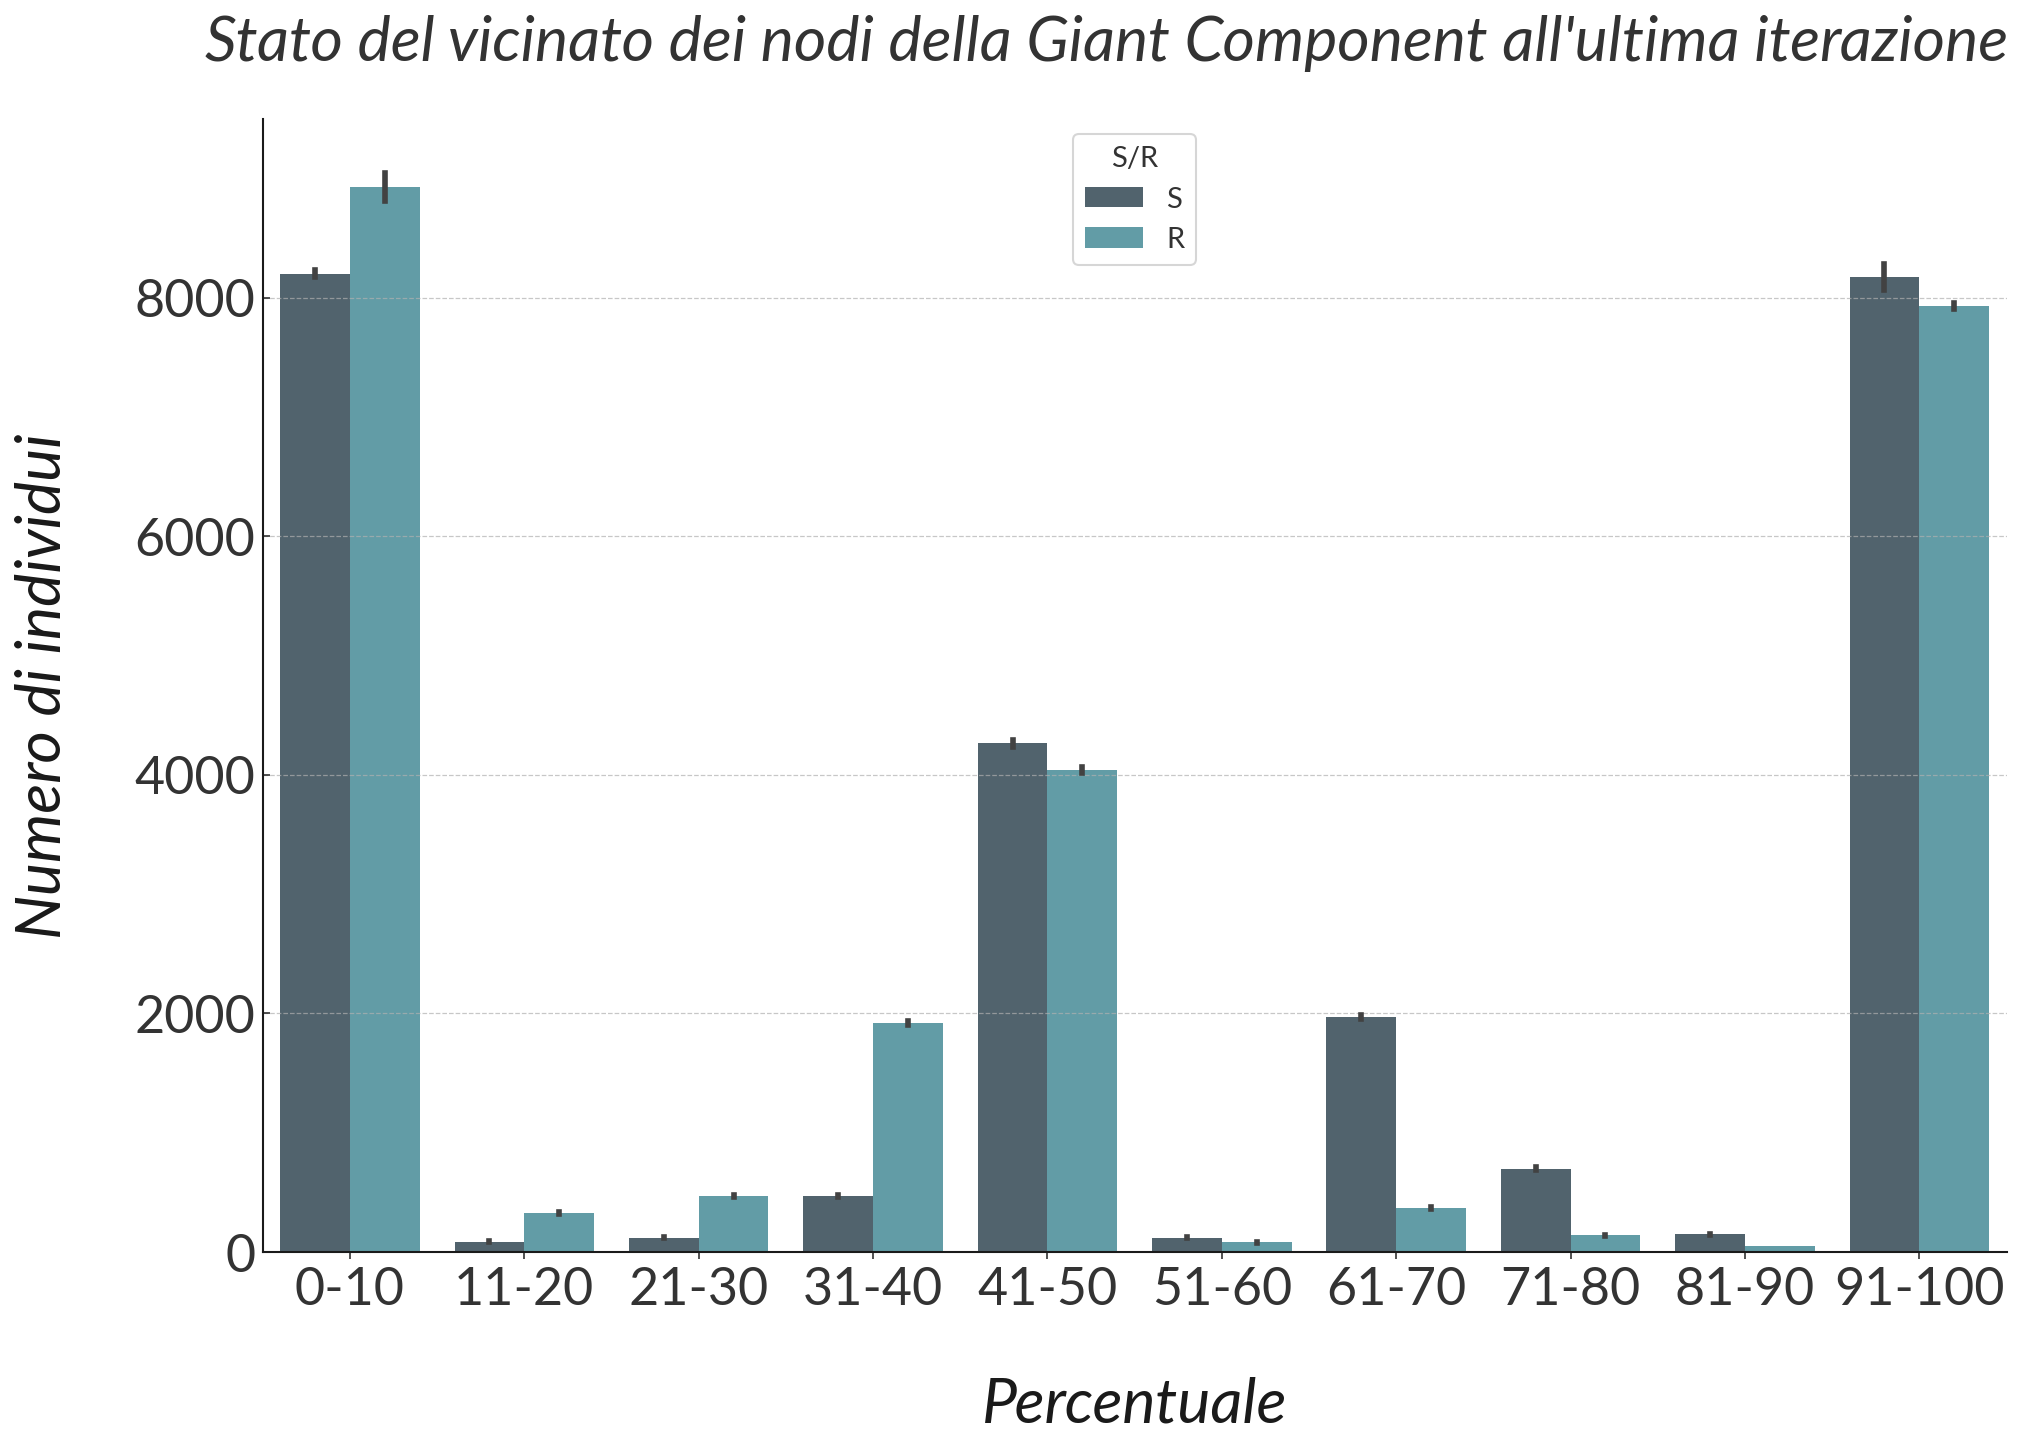

In [837]:
%matplotlib inline
#Check if herd immunity has ben achieved inside the giant component G0

##START FOR EACH
#Collect this data per simulation basis
G0_susceptible = []
G0_neighbors = []
G0_neighbors_s = []
G0_neighbors_r = []
df = pd.DataFrame(columns=['Percentuale', 'Numero di individui', 'S/R'])

for sim in simulations:
    #Create list of sums
    G0_susceptible.append(len(sim['herd_immunity_gc']['nodelist']))
    G0_neighbors.append(sim['herd_immunity_gc']['neighbors'])
    G0_neighbors_s.append(sim['herd_immunity_gc']['s'])
    G0_neighbors_r.append(sim['herd_immunity_gc']['r'])
##END FOR EACH

#Create a list with values to be plotted
dist_temp_s = {'0-10':[],'11-20':[],'21-30':[],'31-40':[],'41-50':[],'51-60':[],'61-70':[],'71-80':[],'81-90':[],'91-100':[]}
dist_temp_r = {'0-10':[],'11-20':[],'21-30':[],'31-40':[],'41-50':[],'51-60':[],'61-70':[],'71-80':[],'81-90':[],'91-100':[]}

#{node:percent}
for i in dist_temp_r:
    interval = i.split('-')
    interval = [int(interval[0]),int(interval[1])]
    #taking interval as [x,x]
    for sim in simulations:
        val_s = 0
        val_r = 0
        for val in list(sim['herd_immunity_gc']['r'].values()):
            if val[0] >= interval[0] and val[0] <= interval[1]:
                val_r += 1
        for val in list(sim['herd_immunity_gc']['s'].values()):
            if val[0] >= interval[0] and val[0] <= interval[1]:
                val_s += 1
        dist_temp_s[i].append(val_s)
        dist_temp_r[i].append(val_r)
        df = df.append({'Percentuale':i,'Numero di individui':val_s,'S/R':'S'},ignore_index=True)
        df = df.append({'Percentuale':i,'Numero di individui':val_r,'S/R':'R'},ignore_index=True)

print(df)
print()
plt.style.use('style.mplstyle')
ax = sns.barplot(x="Percentuale", y="Numero di individui", hue="S/R", data=df, ci=95)
ax.set_xlabel("Percentuale", labelpad=30, style='italic')
ax.set_ylabel("Numero di individui", labelpad=30, style='italic')
plt.suptitle("Stato del vicinato dei nodi della Giant Component all'ultima iterazione", style='italic', y=0.95)
plt.savefig('export_multi_full/G0_herd_immunity.png')

print("Nodi in stato S all'ultima iterazione:",np.mean(G0_susceptible))
print("CI 95%",st.t.interval(alpha=0.95, df=len(G0_susceptible)-1, loc=np.mean(G0_susceptible), scale=st.sem(G0_susceptible)))
print()

print("Numero di neighbors dei nodi con stato S all'ultima iterazione:",np.mean([len(n) for n in G0_neighbors]))
print("CI 95%",st.t.interval(alpha=0.95, df=len([len(n) for n in G0_neighbors])-1, loc=np.mean([len(n) for n in G0_neighbors]), scale=st.sem([len(n) for n in G0_neighbors])))
print()

G0_NS = []
G0_NIE = []
G0_NR = []
for iteration_neighbors in G0_neighbors:
    NS = 0
    NIE = 0
    NR = 0
    for i in iteration_neighbors:
        if iteration_neighbors[i] == 0: NS += 1
        elif iteration_neighbors[i] == 5: NR += 1
        else: NIE +=1
    G0_NS.append(NS)
    G0_NIE.append(NIE)
    G0_NR.append(NR)

print("S:",np.mean(G0_NS),"R:",np.mean(G0_NR),"EAS/IAS:",np.mean(G0_NIE))
print("CI 95%")
print("S",st.t.interval(alpha=0.95, df=len(G0_NS)-1, loc=np.mean(G0_NS), scale=st.sem(G0_NS)))
print("R",st.t.interval(alpha=0.95, df=len(G0_NR)-1, loc=np.mean(G0_NR), scale=st.sem(G0_NR)))
print("EAS/IAS",st.t.interval(alpha=0.95, df=len(G0_NIE)-1, loc=np.mean(G0_NIE), scale=st.sem(G0_NIE)))

In [839]:
%matplotlib inline
sim_giovani_a = []
sim_giovani_s = []
sim_attivi_a = []
sim_attivi_s = []
sim_anziani_a = []
sim_anziani_s = []

#Store values of each simulation
for sim in simulations:
    sim_giovani_a.append(sim['progression']['giovani_a'])
    sim_giovani_s.append(sim['progression']['giovani_s'])
    sim_attivi_a.append(sim['progression']['attivi_a'])
    sim_attivi_s.append(sim['progression']['attivi_s'])
    sim_anziani_a.append(sim['progression']['anziani_a'])
    sim_anziani_s.append(sim['progression']['anziani_s'])

#Calculate mean values of each class
CI_giovani_a = {}
CI_giovani_s = {}
CI_attivi_a = {}
CI_attivi_s = {}
CI_anziani_a = {}
CI_anziani_s = {}

giovani_a = {}
giovani_s = {}
attivi_a = {}
attivi_s = {}
anziani_a = {}
anziani_s = {}

for i in range(0,len(sim_giovani_a[0])):#Num of iterations per simulation (60)
    values = []
    for index in range (0,len(sim_giovani_a)):#Num of simulations (50)
        values.append(sim_giovani_a[index][i])
    giovani_a[i] = np.mean(values)
    CI_giovani_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_giovani_a[i][0]) == True and np.isnan(CI_giovani_a[i][1]) == True: CI_giovani_a[i] = (0,0)
    
for i in range(0,len(sim_giovani_s[0])):
    values = []
    for index in range (0,len(sim_giovani_s)):
        values.append(sim_giovani_s[index][i])
    giovani_s[i] = np.mean(values)
    CI_giovani_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_giovani_s[i][0]) == True and np.isnan(CI_giovani_s[i][1]) == True: CI_giovani_s[i] = (0,0)
        
for i in range(0,len(sim_attivi_a[0])):
    values = []
    for index in range (0,len(sim_attivi_a)):
        values.append(sim_attivi_a[index][i])
    attivi_a[i] = np.mean(values)
    CI_attivi_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_attivi_a[i][0]) == True and np.isnan(CI_attivi_a[i][1]) == True: CI_attivi_a[i] = (0,0)

for i in range(0,len(sim_attivi_s[0])):
    values = []
    for index in range (0,len(sim_attivi_s)):
        values.append(sim_attivi_s[index][i])
    attivi_s[i] = np.mean(values)
    CI_attivi_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_attivi_s[i][0]) == True and np.isnan(CI_attivi_s[i][1]) == True: CI_attivi_s[i] = (0,0)

for i in range(0,len(sim_anziani_a[0])):
    values = []
    for index in range (0,len(sim_anziani_a)):
        values.append(sim_anziani_a[index][i])
    anziani_a[i] = np.mean(values)
    CI_anziani_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_anziani_a[i][0]) == True and np.isnan(CI_anziani_a[i][1]) == True: CI_anziani_a[i] = (0,0)

for i in range(0,len(sim_anziani_s[0])):
    values = []
    for index in range (0,len(sim_anziani_s)):
        values.append(sim_anziani_s[index][i])
    anziani_s[i] = np.mean(values)
    CI_anziani_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_anziani_s[i][0]) == True and np.isnan(CI_anziani_s[i][1]) == True: CI_anziani_s[i] = (0,0)
        
# Make a data frame
dataframes = []
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['simulation'])+1),'Giovani Asintomatici':list(giovani_a.values()),
                 'CI bottom':[CI_giovani_a[i][0] for i in CI_giovani_a],
                 'CI top':[CI_giovani_a[i][1] for i in CI_giovani_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['simulation'])+1),'Giovani Sintomatici':list(giovani_s.values()),
                 'CI bottom':[CI_giovani_s[i][0] for i in CI_giovani_s],
                 'CI top':[CI_giovani_s[i][1] for i in CI_giovani_s]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['simulation'])+1),'Attivi Asintomatici':list(attivi_a.values()),
                 'CI bottom':[CI_attivi_a[i][0] for i in CI_attivi_a],
                 'CI top':[CI_attivi_a[i][1] for i in CI_attivi_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['simulation'])+1),'Attivi Sintomatici':list(attivi_s.values()),
                 'CI bottom':[CI_attivi_s[i][0] for i in CI_attivi_s],
                 'CI top':[CI_attivi_s[i][1] for i in CI_attivi_s]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['simulation'])+1),'Anziani Asintomatici':list(anziani_a.values()),
                 'CI bottom':[CI_anziani_a[i][0] for i in CI_anziani_a],
                 'CI top':[CI_anziani_a[i][1] for i in CI_anziani_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['simulation'])+1),'Anziani Sintomatici':list(anziani_s.values()),
                 'CI bottom':[CI_anziani_s[i][0] for i in CI_anziani_s],
                 'CI top':[CI_anziani_s[i][1] for i in CI_anziani_s]}))

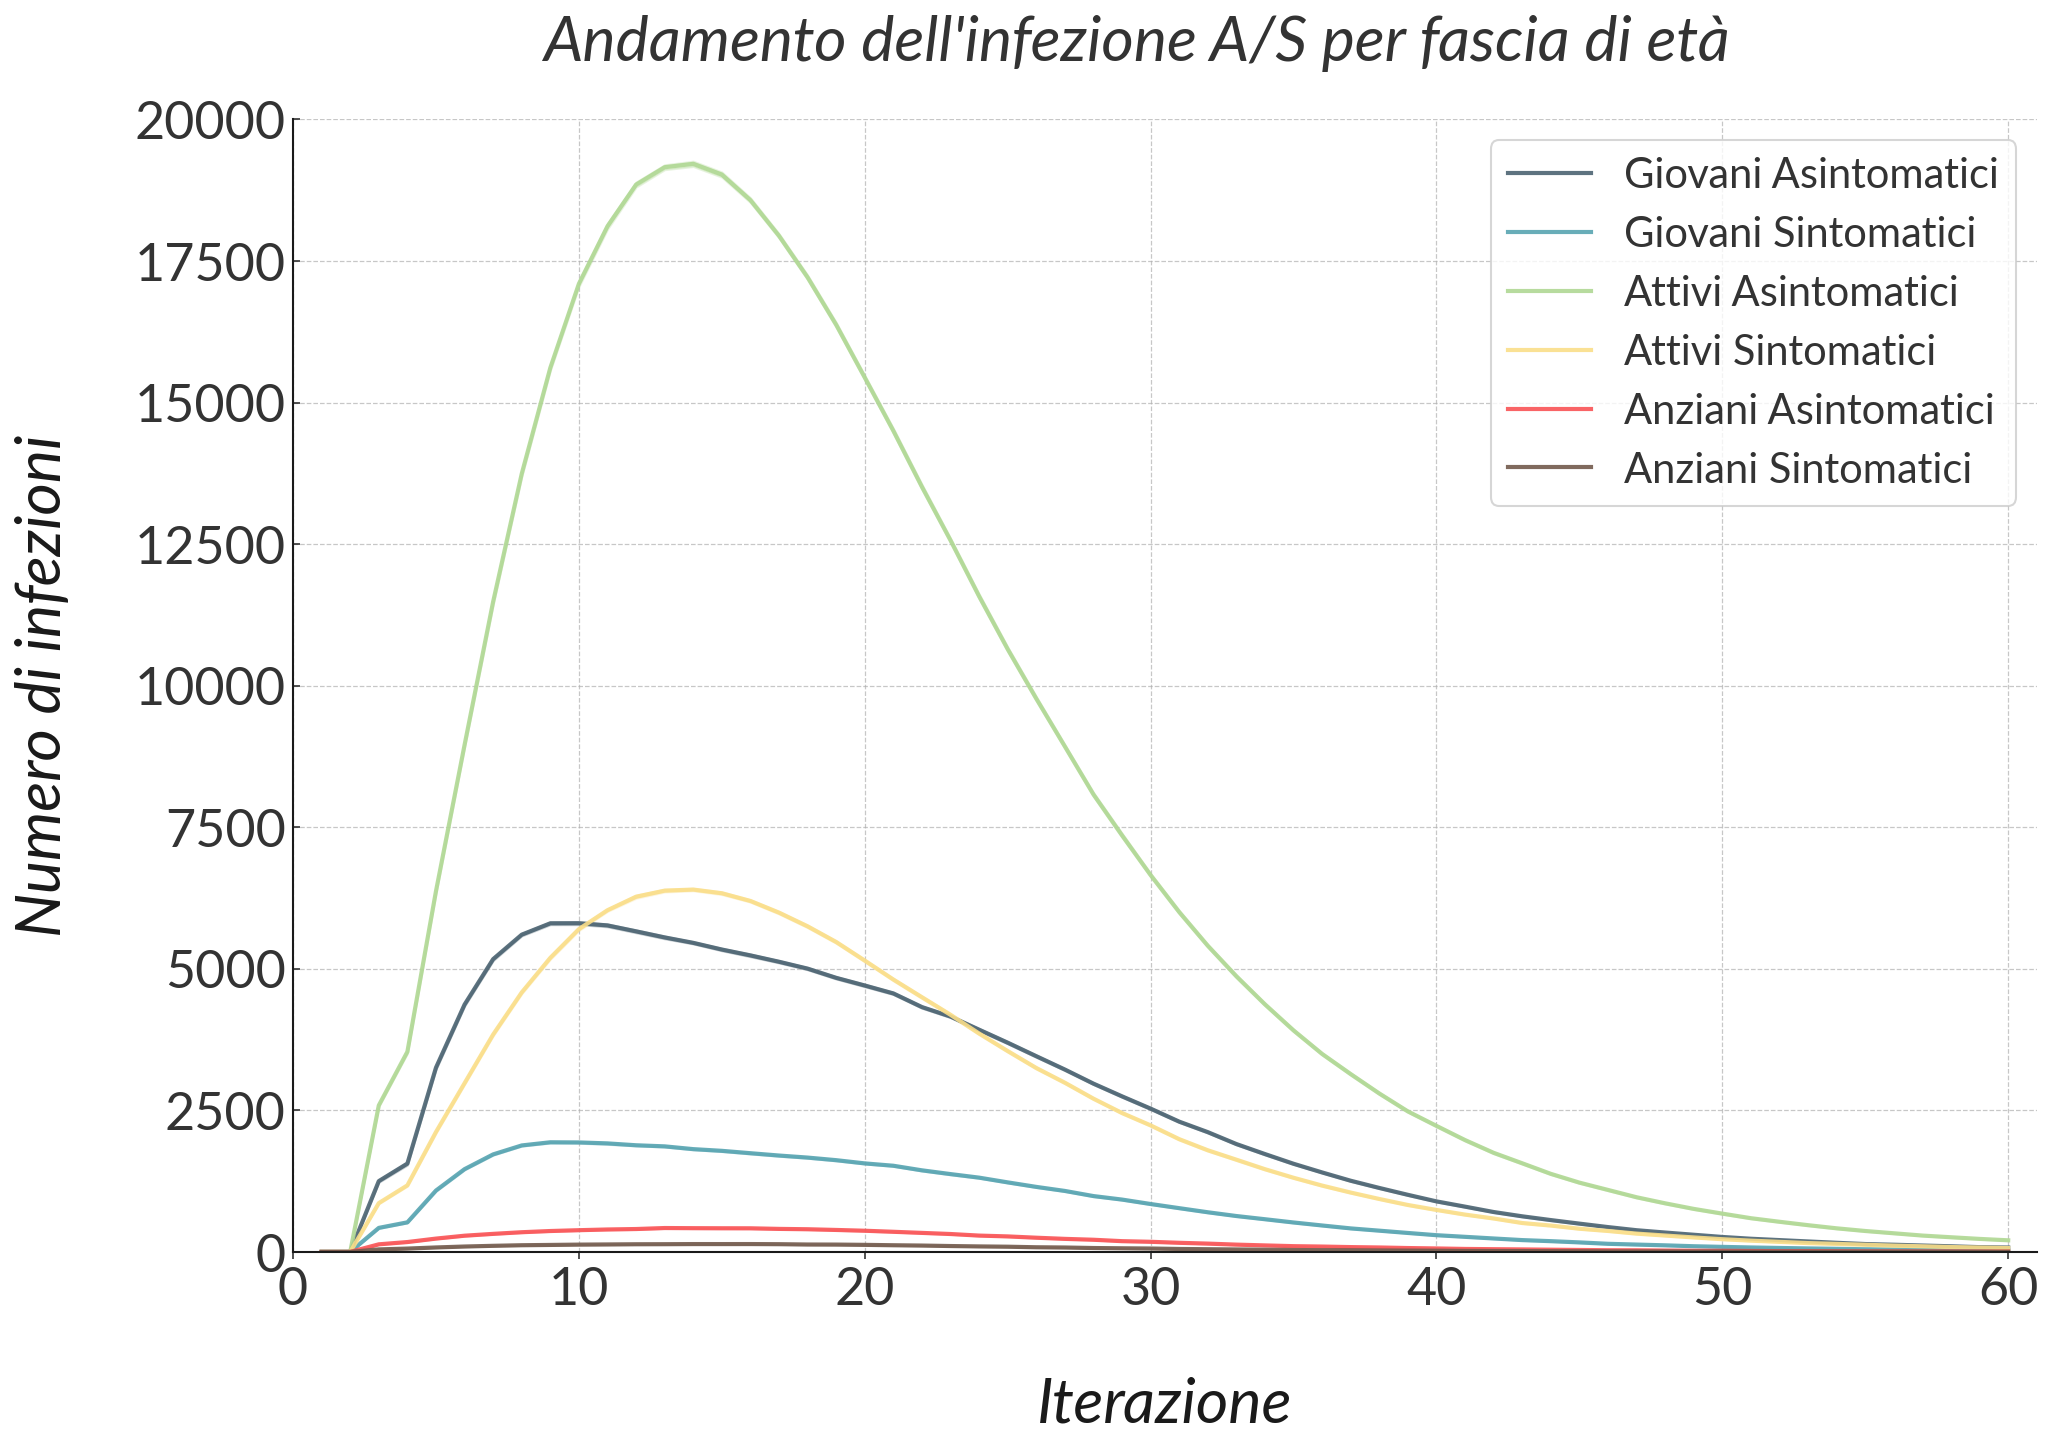

In [840]:
%matplotlib inline
# style
plt.style.use('style.mplstyle')

# create a color palette
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# multiple line plot
num = 0
for df in dataframes:
    for column in df.drop('x', axis=1):
        if column != 'CI bottom' and column != 'CI top':
            plt.plot(df['x'], df[column], marker='', color=palette[num], linewidth=2, alpha=0.9, label=column)
            plt.plot(df['x'], df['CI bottom'], marker='', color=palette[num], linewidth=0, alpha=0)
            plt.plot(df['x'], df['CI top'], marker='', color=palette[num], linewidth=0, alpha=0)
            plt.fill_between(df['x'], df['CI bottom'], df['CI top'], color=palette[num], alpha=0.3, linewidth=1)
            plt.xlim(0,61)
            plt.ylim(0,20000)
            num += 1
                                                             

#Add legend
plt.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=20)

#Titles
plt.xlabel("Iterazione", labelpad=30, style='italic')
plt.ylabel("Numero di infezioni", labelpad=30, style='italic')
plt.suptitle("Andamento dell'infezione A/S per fascia di età", style='italic', y=0.95)

plt.savefig('export_multi_full/progression_single.png')

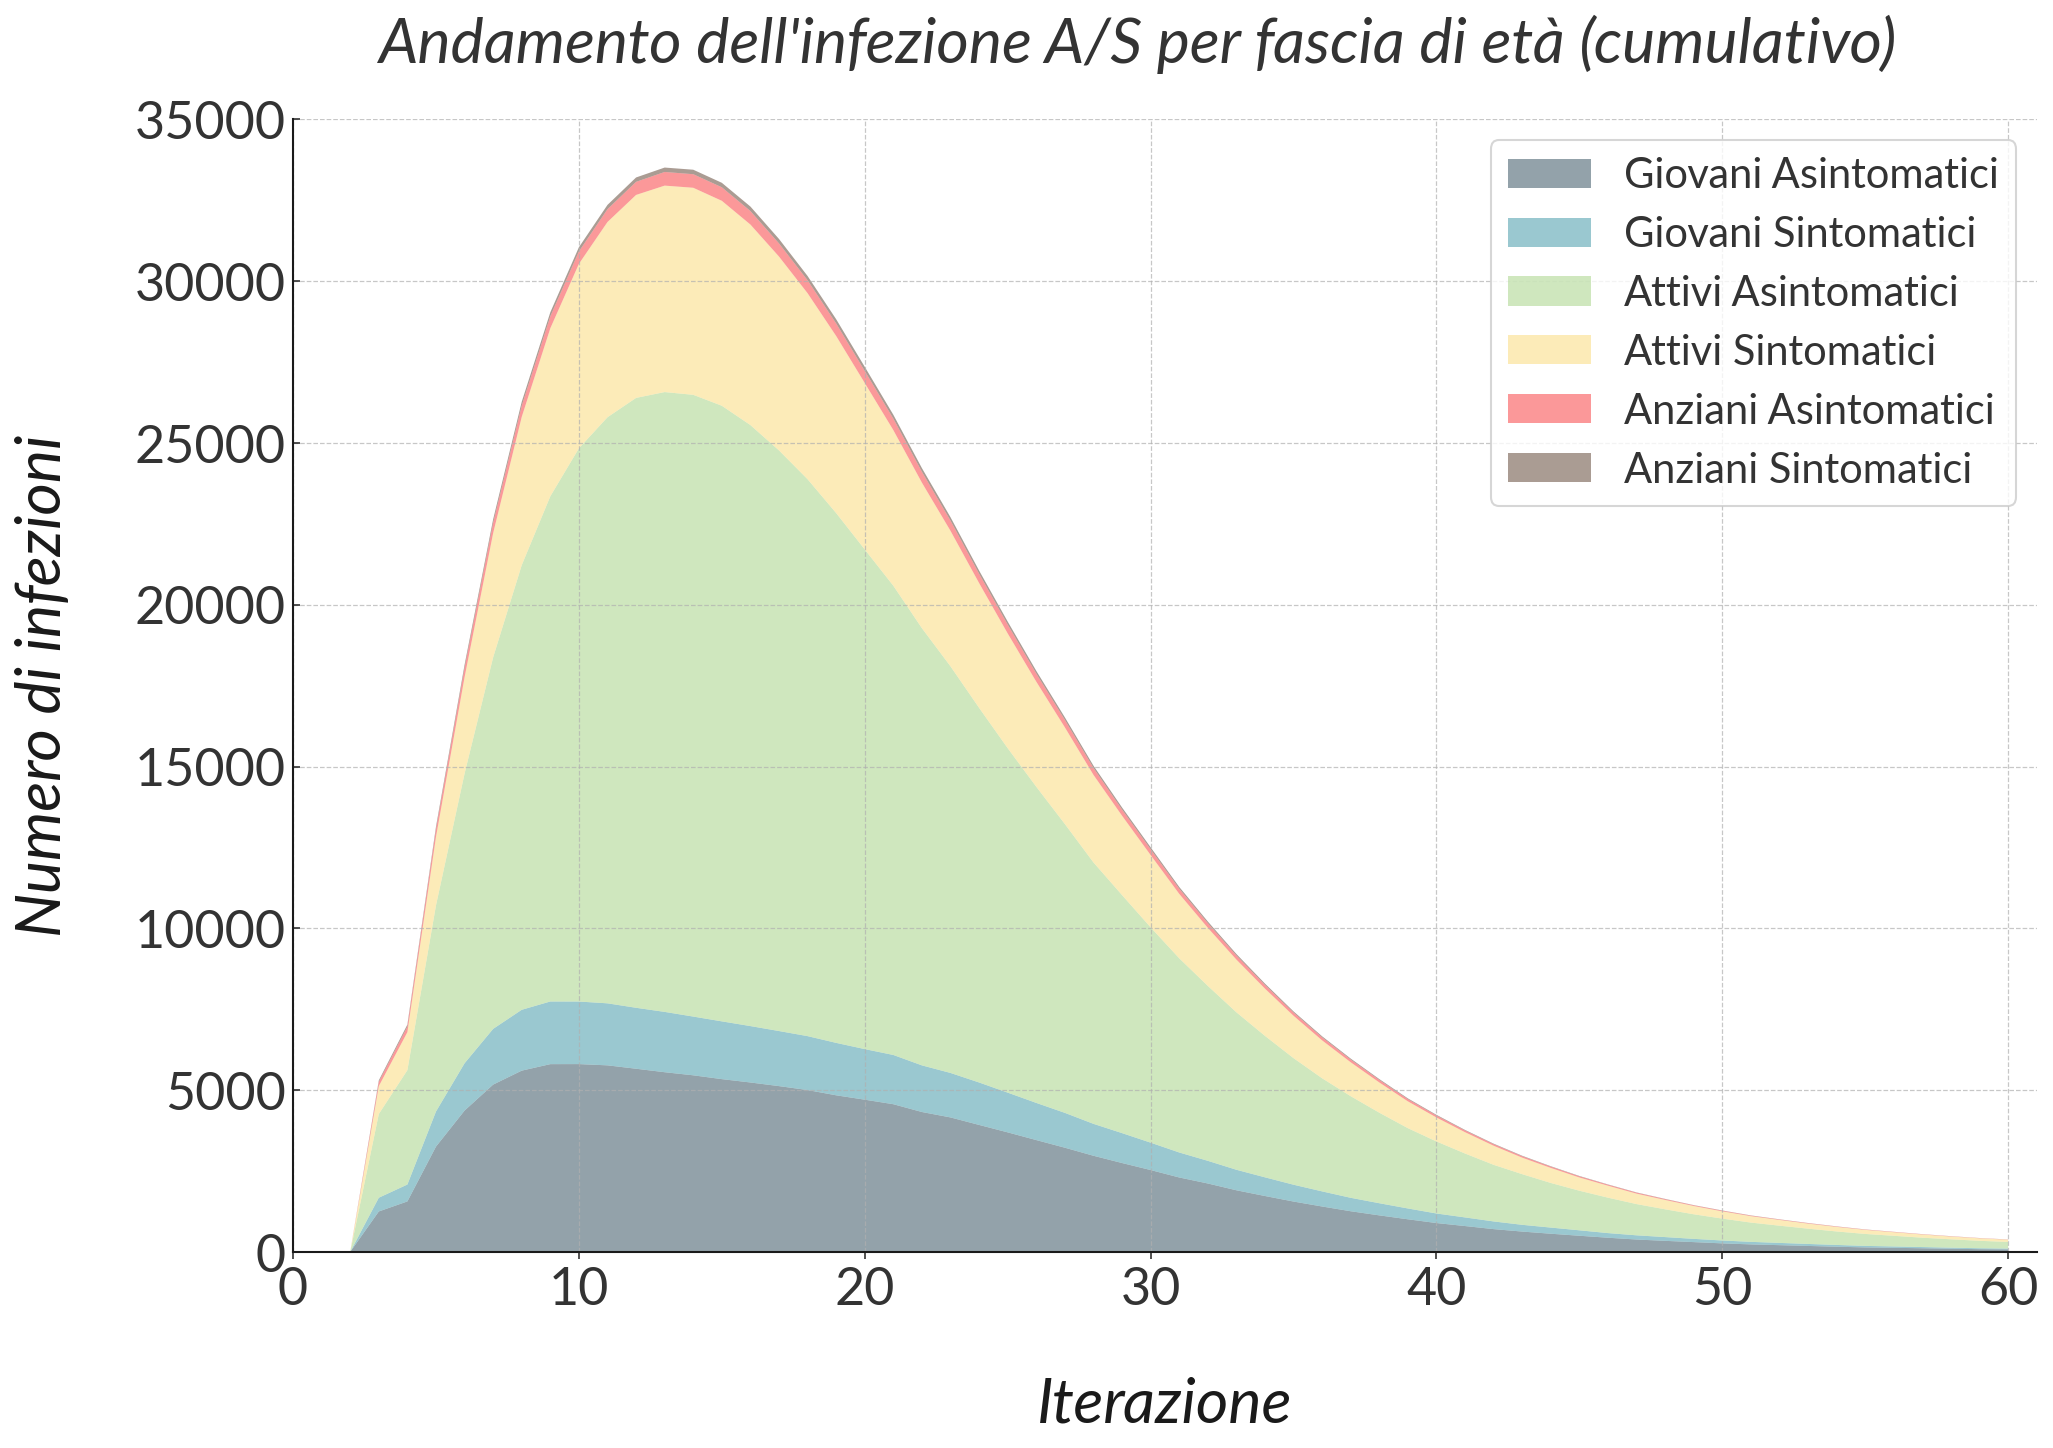

In [843]:
# library

# Your x and y axis
x=range(1,len(simulations[0]['simulation'])+1)
y=[list(giovani_a.values()),list(giovani_s.values()),list(attivi_a.values()),list(attivi_s.values()),list(anziani_a.values()),list(anziani_s.values())]
 
# use a known color palette (see..)
plt.style.use('style.mplstyle')

plt.stackplot(x,y, labels=['Giovani Asintomatici','Giovani Sintomatici','Attivi Asintomatici','Attivi Sintomatici','Anziani Asintomatici','Anziani Sintomatici'], colors=palette, alpha=0.6, linewidth=2 )
plt.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=20)
plt.xlim(0,61)
plt.ylim(0,35000)

#Titles
plt.xlabel("Iterazione", labelpad=30, style='italic')
plt.ylabel("Numero di infezioni", labelpad=30, style='italic')
plt.suptitle("Andamento dell'infezione A/S per fascia di età (cumulativo)", style='italic', y=0.95)
plt.savefig('export_multi_full/progression_single_cumulative.png')

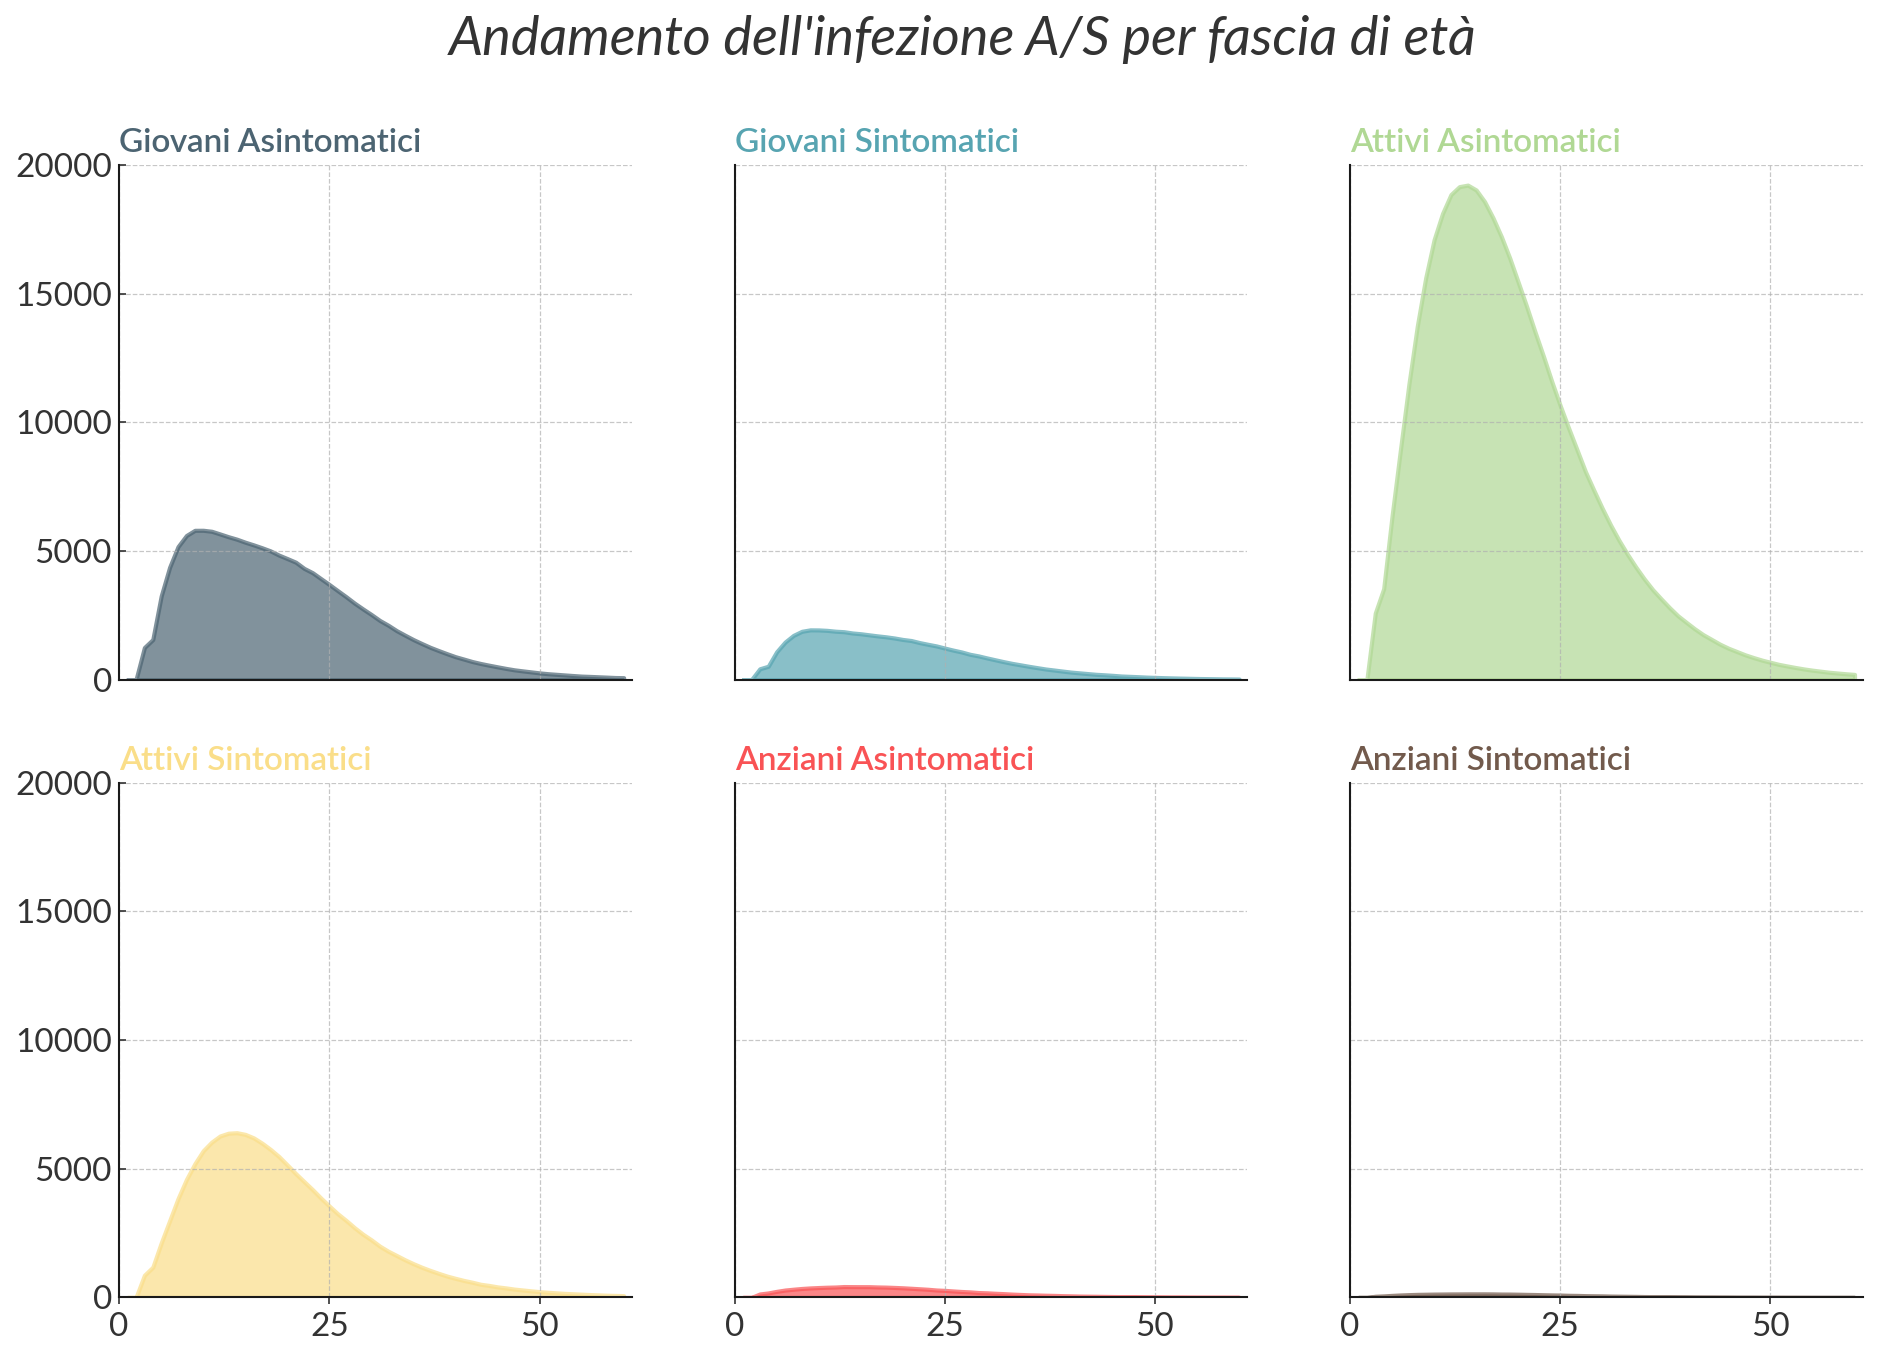

In [849]:
%matplotlib inline
# Initialize the figure
plt.style.use('style.mplstyle')
 
# multiple line plot

num = 0
space = 0
for df in dataframes:
    space += 1
    for column in df.drop('x', axis=1):
        if column != 'CI bottom' and column != 'CI top':
            plt.subplot(2,3, space)
            plt.stackplot(df['x'], df[column], color=palette[num], linewidth=2, alpha=0.7)
            #plt.plot(df['x'], df[column], marker='', color=palette[num], linewidth=1, alpha=0.9, label=column)
            #plt.plot(df['x'], df['CI bottom'], marker='', color=palette[num], linewidth=0, alpha=0)
            #plt.plot(df['x'], df['CI top'], marker='', color=palette[num], linewidth=0, alpha=0)
            #plt.fill_between(df['x'], df['CI bottom'], df['CI top'], color=palette[num], alpha=0.3)
            
            # Same limits for everybody!
            plt.xlim(0,61)
            plt.ylim(0,20000)
            plt.xticks(size = 16)
            plt.yticks(size = 16)
        
            # Not ticks everywhere
            if space in range(4) :
                plt.tick_params(axis='x',labelbottom=False, bottom=False)
            if space not in [1,4] :
                plt.tick_params(axis='y',labelleft=False, left=False)

            # Add title
            plt.title(column, loc='left', fontsize=16, fontweight=600, color=palette[num])
            num += 1
            
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=26, style='italic')

# Axis title
#plt.text(0.5, 0.02, 'Time', ha='center', va='center')
#plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')

plt.savefig('export_multi_full/progression_multi.png')


Mean values
Giovani S/R [43674.14, 158511.48]
Attivi S/R [240423.66, 476873.48]
Anziani S/R [290067.28, 15342.8]

CI 95%
Giovani (S): (43479.81315229621, 43868.46684770379)
Giovani (R): (158313.13655328075, 158709.82344671927)
Attivi (S): (239764.42964449115, 241082.89035550886)
Attivi (R): (476238.8946208405, 477508.06537915947)
Anziani (S): (290004.6432204975, 290129.9167795025)
Anziani (R): (15292.774499498455, 15392.825500501544)


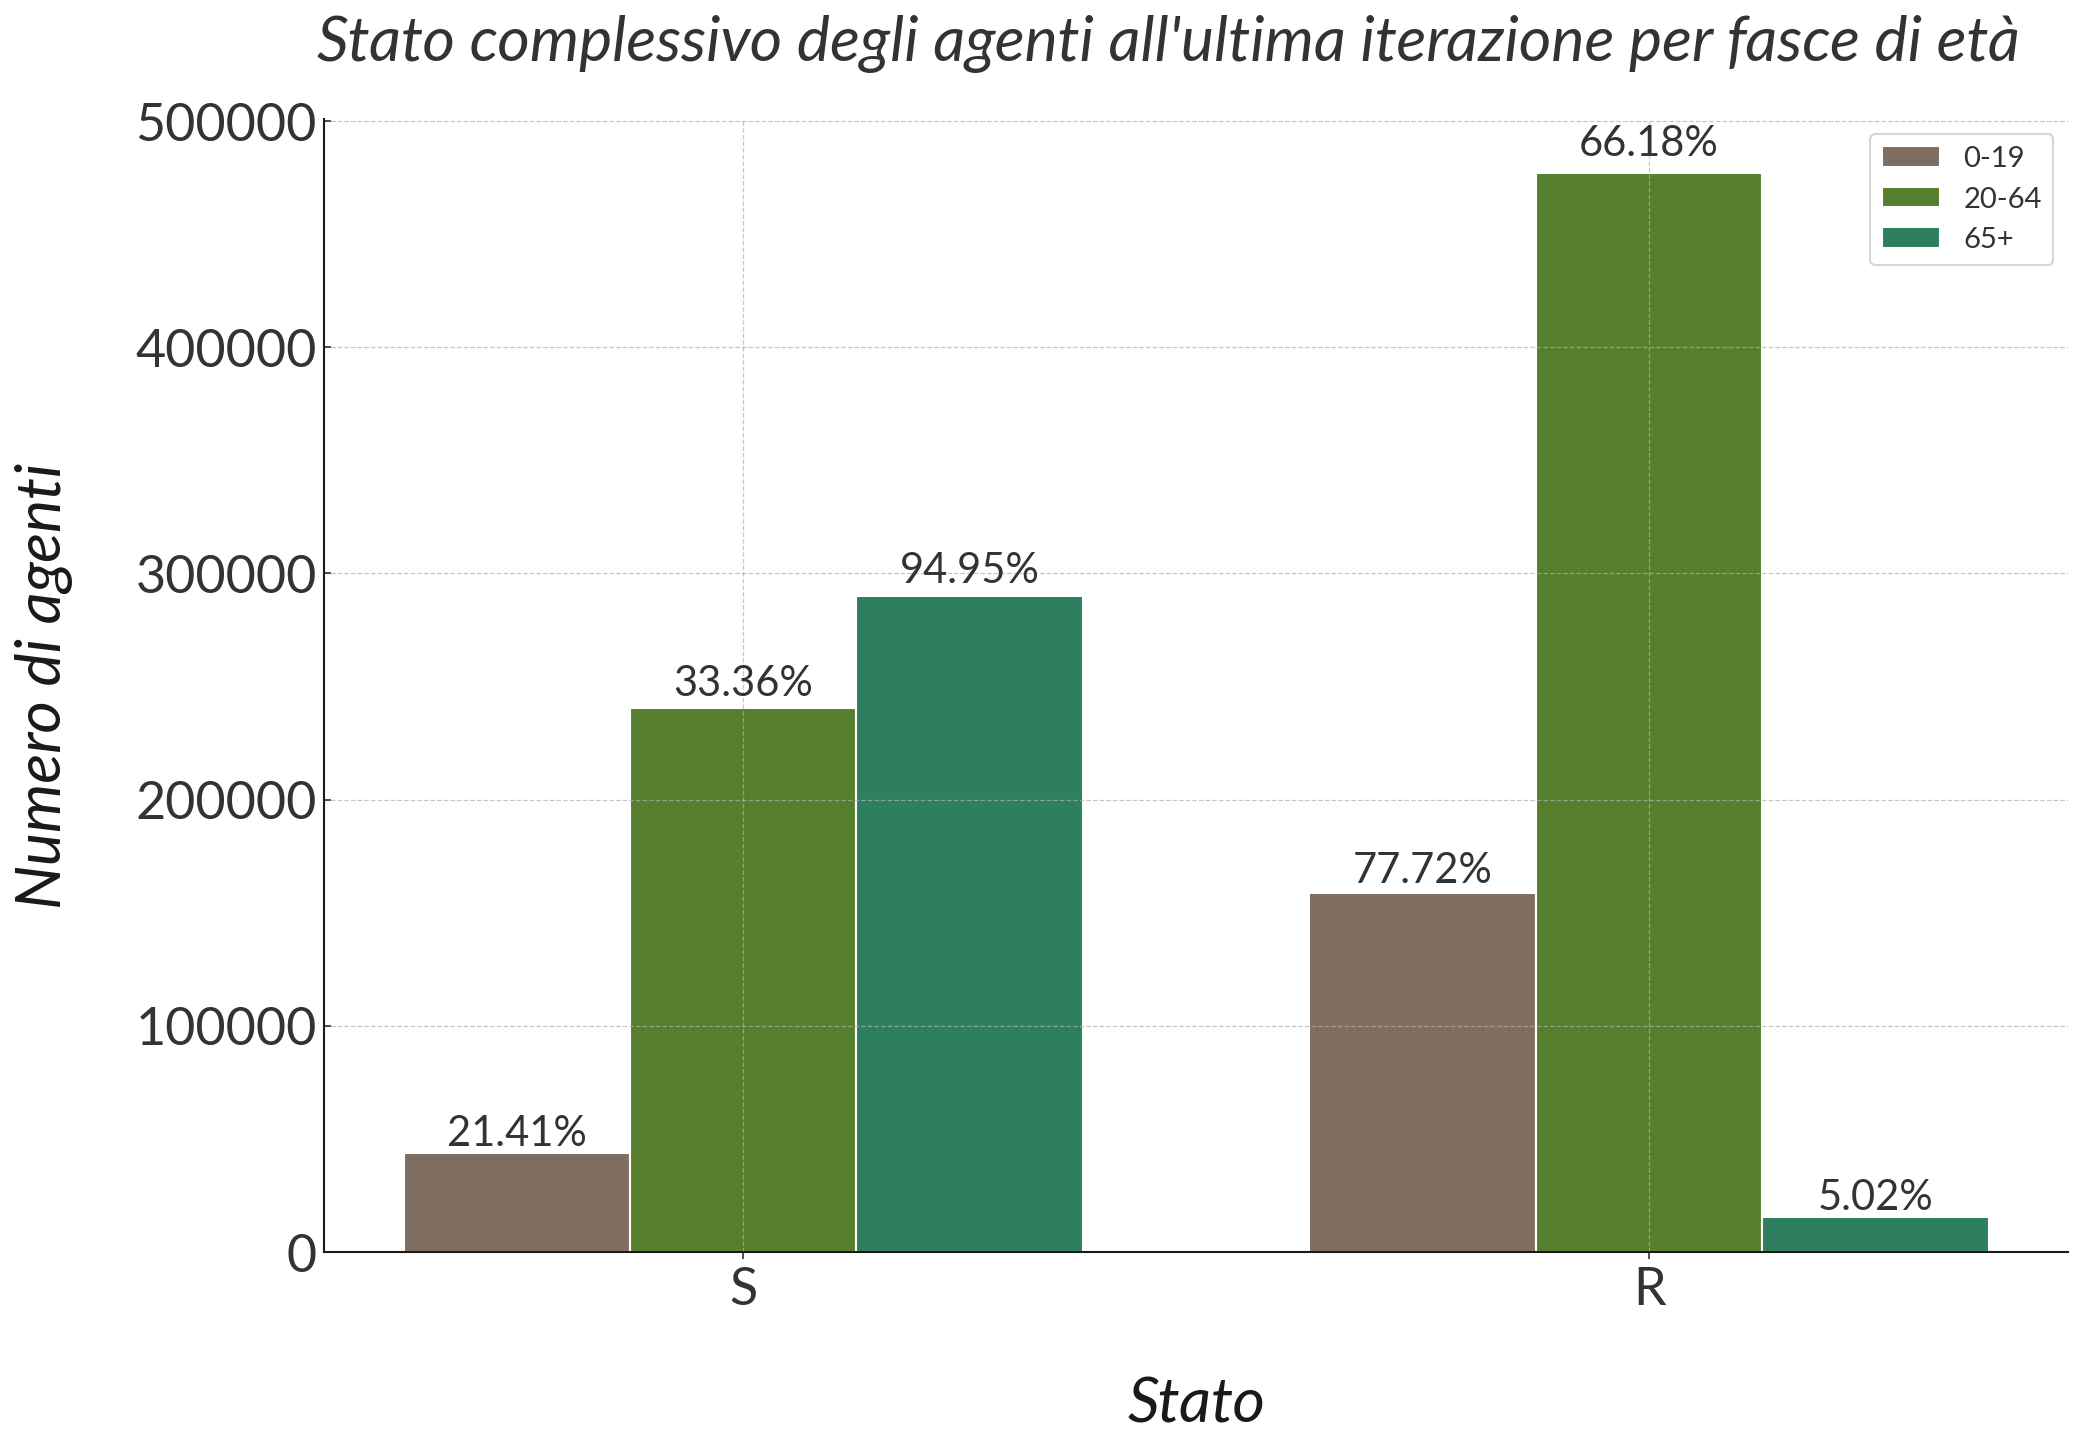

In [852]:
%matplotlib inline
#Create complete status map by dynamically rebuilding infection iteration results
#Keys are nodes, values are final statuses
#Look for keys in graph to get attributes 

##START FOR EACH                
#Calculate how many survivors in absolute at last iter
s_giovani = []
r_giovani = []
s_attivi = []
r_attivi = []
s_anziani = []
r_anziani = []

for sim in simulations:
    #Build sum of age groups 
    giovani_p = []
    attivi_p = []
    anziani_p = []
    for i in sim['noschool_last_iteration_status']['giovani']:
        giovani_p.append(len(sim['noschool_last_iteration_status']['giovani'][i]))
        attivi_p.append(len(sim['noschool_last_iteration_status']['attivi'][i]))
        anziani_p.append(len(sim['noschool_last_iteration_status']['anziani'][i]))

    #Build mean for CI(95%)
    #List "survivors" at last iteration for all simulations
    s_giovani.append(giovani_p[0])
    r_giovani.append(giovani_p[5])
    s_attivi.append(attivi_p[0])
    r_attivi.append(attivi_p[5])
    s_anziani.append(anziani_p[0])
    r_anziani.append(anziani_p[5])
##END FOR EACH

giovani_p = [np.mean(s_giovani),np.mean(r_giovani)]
attivi_p = [np.mean(s_attivi),np.mean(r_attivi)]
anziani_p = [np.mean(s_anziani),np.mean(r_anziani)]

#TODO: PLOT STATUS AT LAST ITERATION 
plt.style.use('style.mplstyle')

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(giovani_p))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
b1 = plt.bar(r1, giovani_p, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-19')
b2 = plt.bar(r2, attivi_p, color='#557f2d', width=barWidth, edgecolor='white', label='20-64')
b3 = plt.bar(r3, anziani_p, color='#2d7f5e', width=barWidth, edgecolor='white', label='65+')

def autolabel(rects,tot_pop):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.01*height, str(round((height/tot_pop)*100,2))+'%', ha='center', va='bottom', size=20)

mean_giovani = np.mean([i['G0_agedistrib']['giovani'] for i in simulations])
mean_attivi = np.mean([i['G0_agedistrib']['attivi'] for i in simulations])
mean_anziani = np.mean([i['G0_agedistrib']['anziani'] for i in simulations])

autolabel(b1, mean_giovani)
autolabel(b2, mean_attivi)
autolabel(b3, mean_anziani)



# Add xticks on the middle of the group bars
# general title
plt.suptitle("Stato complessivo degli agenti all'ultima iterazione per fasce di età", style='italic', y=0.95)
plt.xlabel("Stato", style='italic', labelpad=30)
plt.ylabel("Numero di agenti", style='italic', labelpad=30)
labels = ['S',"R"]
plt.xticks([r + barWidth for r in range(len(giovani_p))], labels)

# 
# Create legend & Show graphic
plt.legend()
plt.savefig('export_multi_full/noschool_last_iteration_statuses.png')

print()
print("Mean values")
print("Giovani S/R", giovani_p)
print("Attivi S/R", attivi_p)
print("Anziani S/R", anziani_p)
print()
print("CI 95%")
print("Giovani (S):",st.t.interval(alpha=0.95, df=len(s_giovani)-1, loc=np.mean(s_giovani), scale=st.sem(s_giovani)))
print("Giovani (R):",st.t.interval(alpha=0.95, df=len(r_giovani)-1, loc=np.mean(r_giovani), scale=st.sem(r_giovani)))
print("Attivi (S):",st.t.interval(alpha=0.95, df=len(s_attivi)-1, loc=np.mean(s_attivi), scale=st.sem(s_attivi)))
print("Attivi (R):",st.t.interval(alpha=0.95, df=len(r_attivi)-1, loc=np.mean(r_attivi), scale=st.sem(r_attivi)))
print("Anziani (S):",st.t.interval(alpha=0.95, df=len(s_anziani)-1, loc=np.mean(s_anziani), scale=st.sem(s_anziani)))
print("Anziani (R):",st.t.interval(alpha=0.95, df=len(r_anziani)-1, loc=np.mean(r_anziani), scale=st.sem(r_anziani)))

    Percentuale Numero di individui S/R
0          0-10                6484   S
1          0-10              120446   R
2          0-10                6522   S
3          0-10              123078   R
4          0-10                6528   S
..          ...                 ...  ..
995      91-100                6338   R
996      91-100              123151   S
997      91-100                6453   R
998      91-100              120708   S
999      91-100                6326   R

[1000 rows x 3 columns]

Nodi in stato S all'ultima iterazione: 146871.2
CI 95% (146070.55792500297, 147671.84207499705)

Numero di neighbors dei nodi con stato S all'ultima iterazione: 198387.66
CI 95% (197631.2127735486, 199144.1072264514)

S: 140466.54 R: 57250.28 EAS/IAS: 670.84
CI 95%
S (139660.75012912622, 141272.3298708738)
R (57144.80025691846, 57355.75974308154)
EAS/IAS (655.5972221421198, 686.0827778578803)


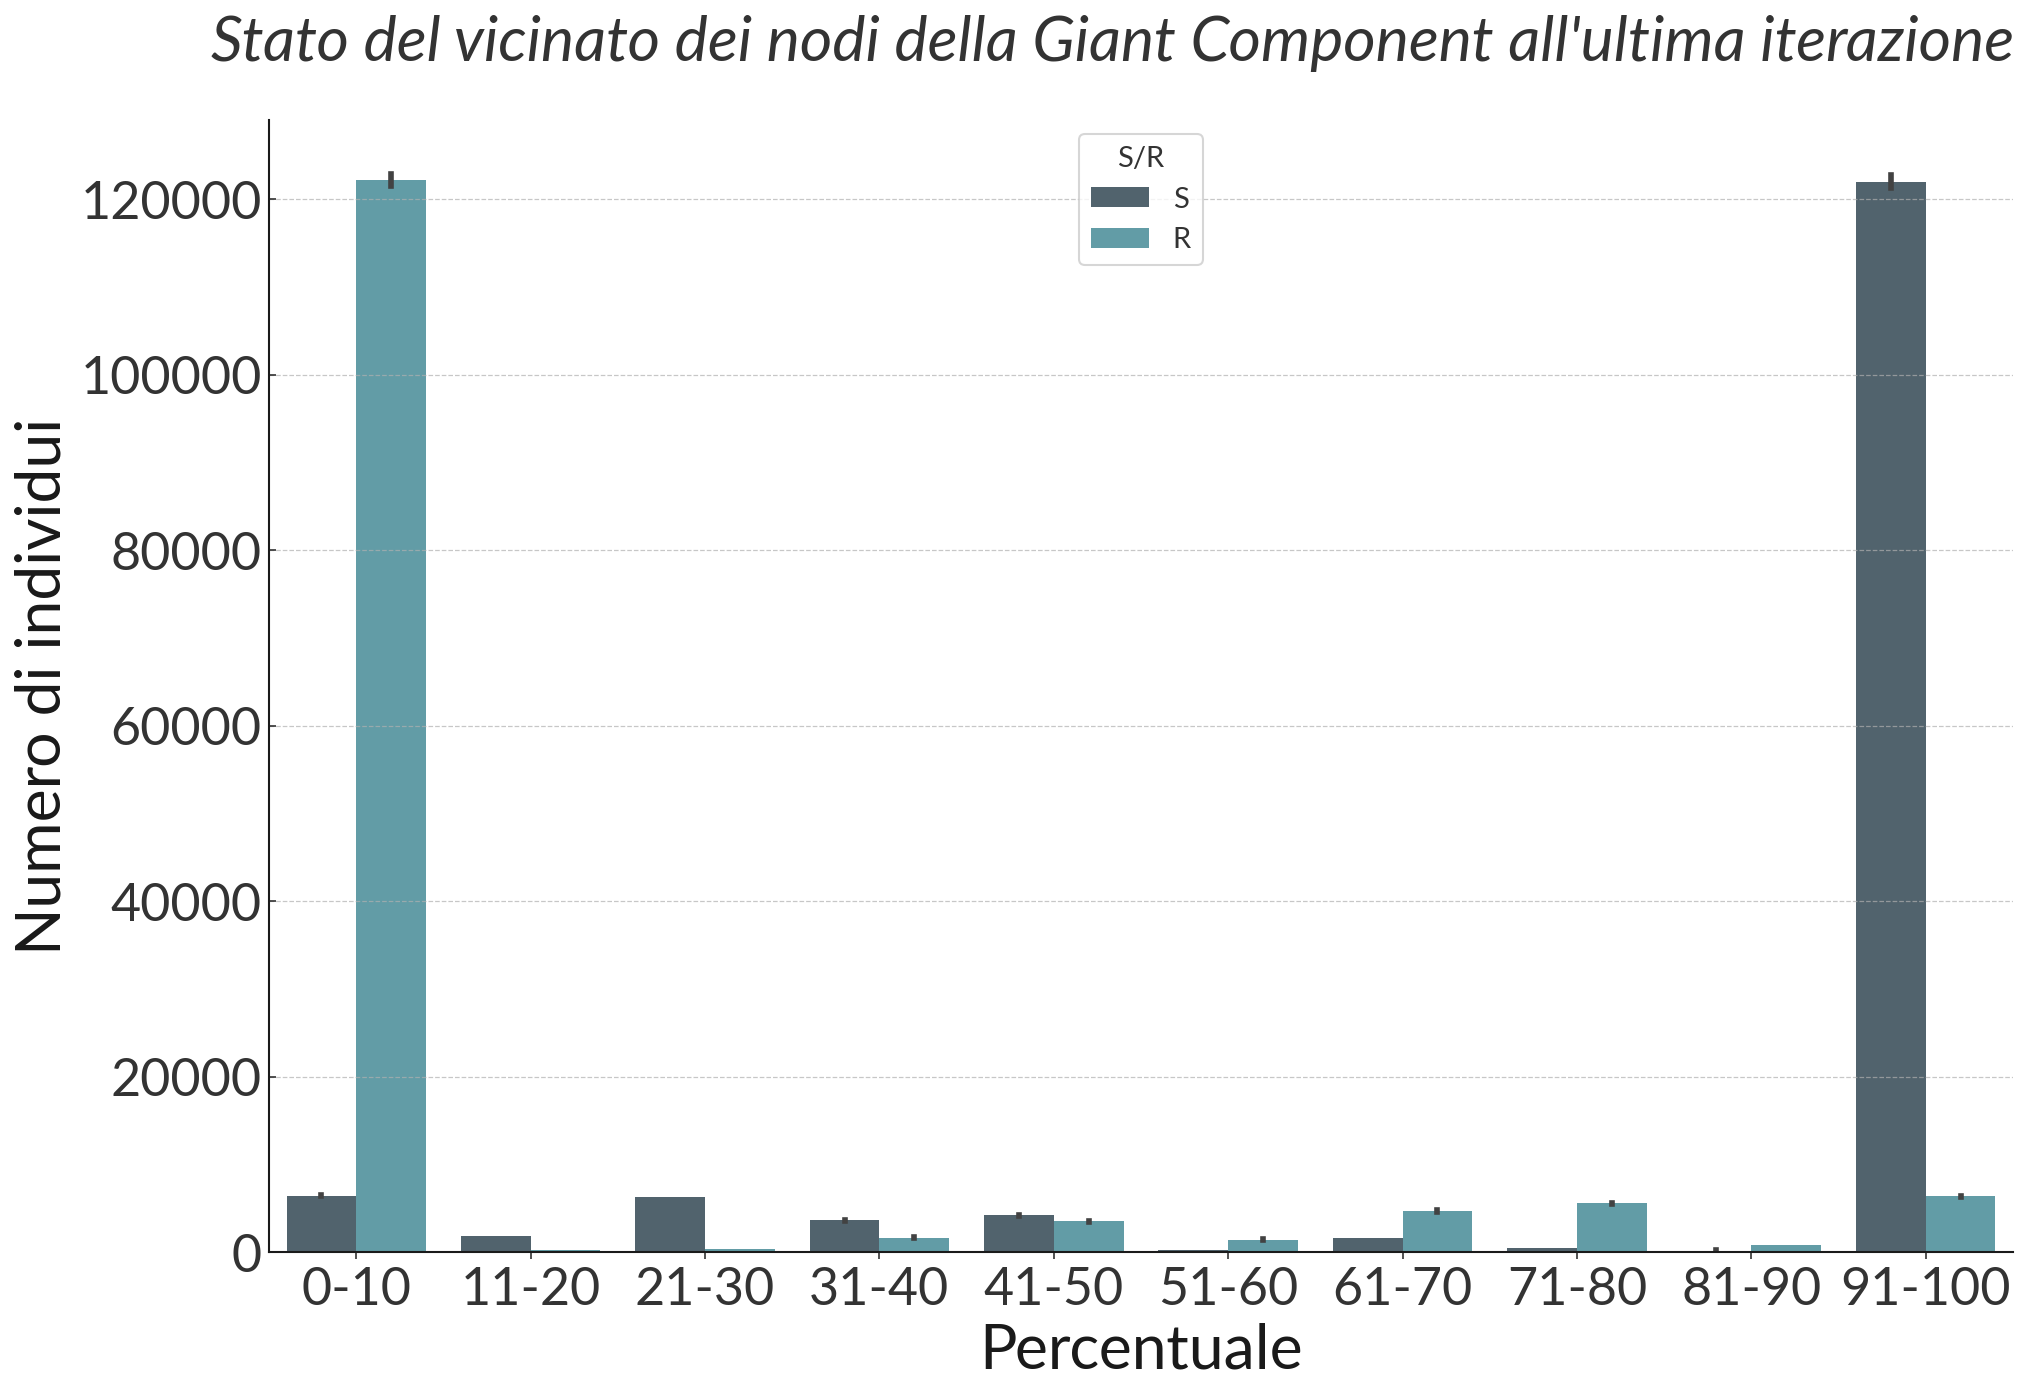

In [853]:
%matplotlib inline
#Check if herd immunity has ben achieved inside the giant component G0

##START FOR EACH
#Collect this data per simulation basis
G0_susceptible = []
G0_neighbors = []
G0_neighbors_s = []
G0_neighbors_r = []
df = pd.DataFrame(columns=['Percentuale', 'Numero di individui', 'S/R'])

for sim in simulations:
    #Create list of sums
    G0_susceptible.append(len(sim['noschool_herd_immunity_gc']['nodelist']))
    G0_neighbors.append(sim['noschool_herd_immunity_gc']['neighbors'])
    G0_neighbors_s.append(sim['noschool_herd_immunity_gc']['s'])
    G0_neighbors_r.append(sim['noschool_herd_immunity_gc']['r'])
##END FOR EACH

#Create a list with values to be plotted
dist_temp_s = {'0-10':[],'11-20':[],'21-30':[],'31-40':[],'41-50':[],'51-60':[],'61-70':[],'71-80':[],'81-90':[],'91-100':[]}
dist_temp_r = {'0-10':[],'11-20':[],'21-30':[],'31-40':[],'41-50':[],'51-60':[],'61-70':[],'71-80':[],'81-90':[],'91-100':[]}

#{node:percent}
for i in dist_temp_r:
    interval = i.split('-')
    interval = [int(interval[0]),int(interval[1])]
    #taking interval as [x,x]
    for sim in simulations:
        val_s = 0
        val_r = 0
        for val in list(sim['noschool_herd_immunity_gc']['r'].values()):
            if val[0] >= interval[0] and val[0] <= interval[1]:
                val_r += 1
        for val in list(sim['noschool_herd_immunity_gc']['s'].values()):
            if val[0] >= interval[0] and val[0] <= interval[1]:
                val_s += 1
        dist_temp_s[i].append(val_s)
        dist_temp_r[i].append(val_r)
        df = df.append({'Percentuale':i,'Numero di individui':val_s,'S/R':'S'},ignore_index=True)
        df = df.append({'Percentuale':i,'Numero di individui':val_r,'S/R':'R'},ignore_index=True)

print(df)
print()
plt.style.use('style.mplstyle')
ax = sns.barplot(x="Percentuale", y="Numero di individui", hue="S/R", data=df, ci=95)
plt.suptitle("Stato del vicinato dei nodi della Giant Component all'ultima iterazione", style='italic', y=0.95)
plt.savefig('export_multi_full/noschool_G0_herd_immunity.png')

print("Nodi in stato S all'ultima iterazione:",np.mean(G0_susceptible))
print("CI 95%",st.t.interval(alpha=0.95, df=len(G0_susceptible)-1, loc=np.mean(G0_susceptible), scale=st.sem(G0_susceptible)))
print()

print("Numero di neighbors dei nodi con stato S all'ultima iterazione:",np.mean([len(n) for n in G0_neighbors]))
print("CI 95%",st.t.interval(alpha=0.95, df=len([len(n) for n in G0_neighbors])-1, loc=np.mean([len(n) for n in G0_neighbors]), scale=st.sem([len(n) for n in G0_neighbors])))
print()

G0_NS = []
G0_NIE = []
G0_NR = []
for iteration_neighbors in G0_neighbors:
    NS = 0
    NIE = 0
    NR = 0
    for i in iteration_neighbors:
        if iteration_neighbors[i] == 0: NS += 1
        elif iteration_neighbors[i] == 5: NR += 1
        else: NIE +=1
    G0_NS.append(NS)
    G0_NIE.append(NIE)
    G0_NR.append(NR)

print("S:",np.mean(G0_NS),"R:",np.mean(G0_NR),"EAS/IAS:",np.mean(G0_NIE))
print("CI 95%")
print("S",st.t.interval(alpha=0.95, df=len(G0_NS)-1, loc=np.mean(G0_NS), scale=st.sem(G0_NS)))
print("R",st.t.interval(alpha=0.95, df=len(G0_NR)-1, loc=np.mean(G0_NR), scale=st.sem(G0_NR)))
print("EAS/IAS",st.t.interval(alpha=0.95, df=len(G0_NIE)-1, loc=np.mean(G0_NIE), scale=st.sem(G0_NIE)))

In [855]:
%matplotlib inline
sim_giovani_a = []
sim_giovani_s = []
sim_attivi_a = []
sim_attivi_s = []
sim_anziani_a = []
sim_anziani_s = []

#Store values of each simulation
for sim in simulations:
    sim_giovani_a.append(sim['noschool_progression']['giovani_a'])
    sim_giovani_s.append(sim['noschool_progression']['giovani_s'])
    sim_attivi_a.append(sim['noschool_progression']['attivi_a'])
    sim_attivi_s.append(sim['noschool_progression']['attivi_s'])
    sim_anziani_a.append(sim['noschool_progression']['anziani_a'])
    sim_anziani_s.append(sim['noschool_progression']['anziani_s'])

#Calculate mean values of each class
CI_giovani_a = {}
CI_giovani_s = {}
CI_attivi_a = {}
CI_attivi_s = {}
CI_anziani_a = {}
CI_anziani_s = {}

giovani_a = {}
giovani_s = {}
attivi_a = {}
attivi_s = {}
anziani_a = {}
anziani_s = {}

for i in range(0,len(sim_giovani_a[0])):#Num of iterations per simulation (60)
    values = []
    for index in range (0,len(sim_giovani_a)):#Num of simulations (50)
        values.append(sim_giovani_a[index][i])
    giovani_a[i] = np.mean(values)
    CI_giovani_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_giovani_a[i][0]) == True and np.isnan(CI_giovani_a[i][1]) == True: CI_giovani_a[i] = (0,0)
    
for i in range(0,len(sim_giovani_s[0])):
    values = []
    for index in range (0,len(sim_giovani_s)):
        values.append(sim_giovani_s[index][i])
    giovani_s[i] = np.mean(values)
    CI_giovani_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_giovani_s[i][0]) == True and np.isnan(CI_giovani_s[i][1]) == True: CI_giovani_s[i] = (0,0)
        
for i in range(0,len(sim_attivi_a[0])):
    values = []
    for index in range (0,len(sim_attivi_a)):
        values.append(sim_attivi_a[index][i])
    attivi_a[i] = np.mean(values)
    CI_attivi_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_attivi_a[i][0]) == True and np.isnan(CI_attivi_a[i][1]) == True: CI_attivi_a[i] = (0,0)

for i in range(0,len(sim_attivi_s[0])):
    values = []
    for index in range (0,len(sim_attivi_s)):
        values.append(sim_attivi_s[index][i])
    attivi_s[i] = np.mean(values)
    CI_attivi_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_attivi_s[i][0]) == True and np.isnan(CI_attivi_s[i][1]) == True: CI_attivi_s[i] = (0,0)

for i in range(0,len(sim_anziani_a[0])):
    values = []
    for index in range (0,len(sim_anziani_a)):
        values.append(sim_anziani_a[index][i])
    anziani_a[i] = np.mean(values)
    CI_anziani_a[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_anziani_a[i][0]) == True and np.isnan(CI_anziani_a[i][1]) == True: CI_anziani_a[i] = (0,0)

for i in range(0,len(sim_anziani_s[0])):
    values = []
    for index in range (0,len(sim_anziani_s)):
        values.append(sim_anziani_s[index][i])
    anziani_s[i] = np.mean(values)
    CI_anziani_s[i] = st.t.interval(alpha=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if np.isnan(CI_anziani_s[i][0]) == True and np.isnan(CI_anziani_s[i][1]) == True: CI_anziani_s[i] = (0,0)
        
# Make a data frame
dataframes = []
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['noschool_simulation'])+1),'Giovani Asintomatici':list(giovani_a.values()),
                 'CI bottom':[CI_giovani_a[i][0] for i in CI_giovani_a],
                 'CI top':[CI_giovani_a[i][1] for i in CI_giovani_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['noschool_simulation'])+1),'Giovani Sintomatici':list(giovani_s.values()),
                 'CI bottom':[CI_giovani_s[i][0] for i in CI_giovani_s],
                 'CI top':[CI_giovani_s[i][1] for i in CI_giovani_s]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['noschool_simulation'])+1),'Attivi Asintomatici':list(attivi_a.values()),
                 'CI bottom':[CI_attivi_a[i][0] for i in CI_attivi_a],
                 'CI top':[CI_attivi_a[i][1] for i in CI_attivi_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['noschool_simulation'])+1),'Attivi Sintomatici':list(attivi_s.values()),
                 'CI bottom':[CI_attivi_s[i][0] for i in CI_attivi_s],
                 'CI top':[CI_attivi_s[i][1] for i in CI_attivi_s]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['noschool_simulation'])+1),'Anziani Asintomatici':list(anziani_a.values()),
                 'CI bottom':[CI_anziani_a[i][0] for i in CI_anziani_a],
                 'CI top':[CI_anziani_a[i][1] for i in CI_anziani_a]}))
# Make a data frame
dataframes.append(pd.DataFrame({'x': range(1,len(simulations[0]['noschool_simulation'])+1),'Anziani Sintomatici':list(anziani_s.values()),
                 'CI bottom':[CI_anziani_s[i][0] for i in CI_anziani_s],
                 'CI top':[CI_anziani_s[i][1] for i in CI_anziani_s]}))

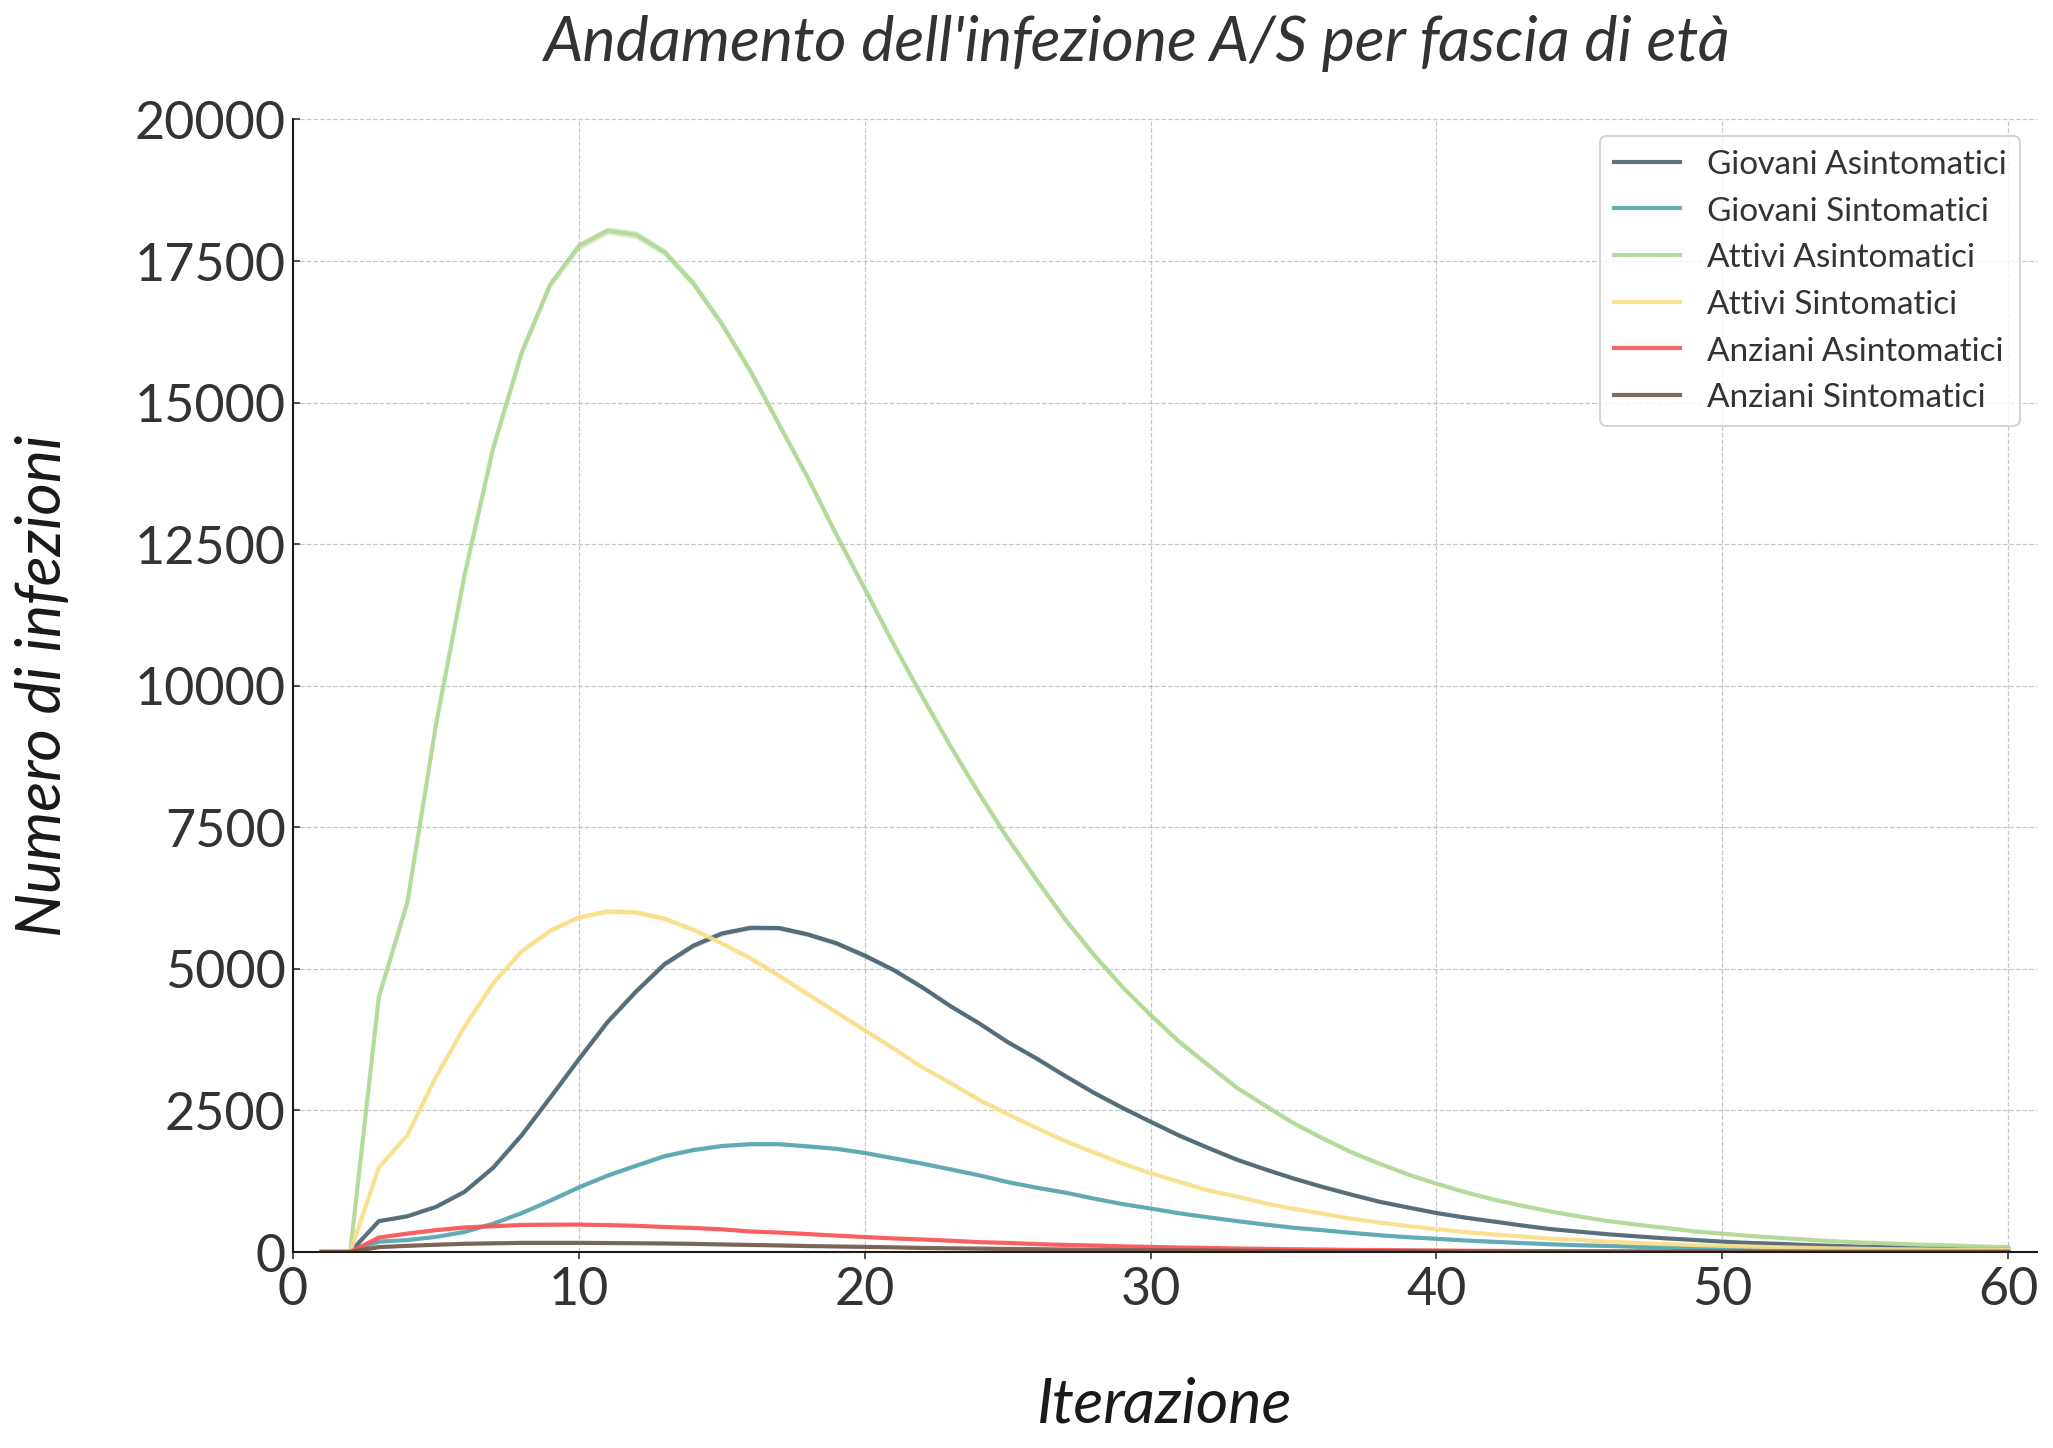

In [856]:
%matplotlib inline
# style
plt.style.use('style.mplstyle')

# create a color palette
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# multiple line plot
num = 0
for df in dataframes:
    for column in df.drop('x', axis=1):
        if column != 'CI bottom' and column != 'CI top':
            plt.plot(df['x'], df[column], marker='', color=palette[num], linewidth=2, alpha=0.9, label=column)
            plt.plot(df['x'], df['CI bottom'], marker='', color=palette[num], linewidth=0, alpha=0)
            plt.plot(df['x'], df['CI top'], marker='', color=palette[num], linewidth=0, alpha=0)
            plt.fill_between(df['x'], df['CI bottom'], df['CI top'], color=palette[num], alpha=0.3, linewidth=1)
            plt.xlim(0,61)
            plt.ylim(0,20000)
            num += 1
                                                             

#Add legend
plt.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=16)

#Titles
plt.xlabel("Iterazione", style='italic', labelpad=30)
plt.ylabel("Numero di infezioni", style='italic', labelpad=30)
plt.suptitle("Andamento dell'infezione A/S per fascia di età", style='italic', y=0.95)

plt.savefig('export_multi_full/noschool_progression_single.png')

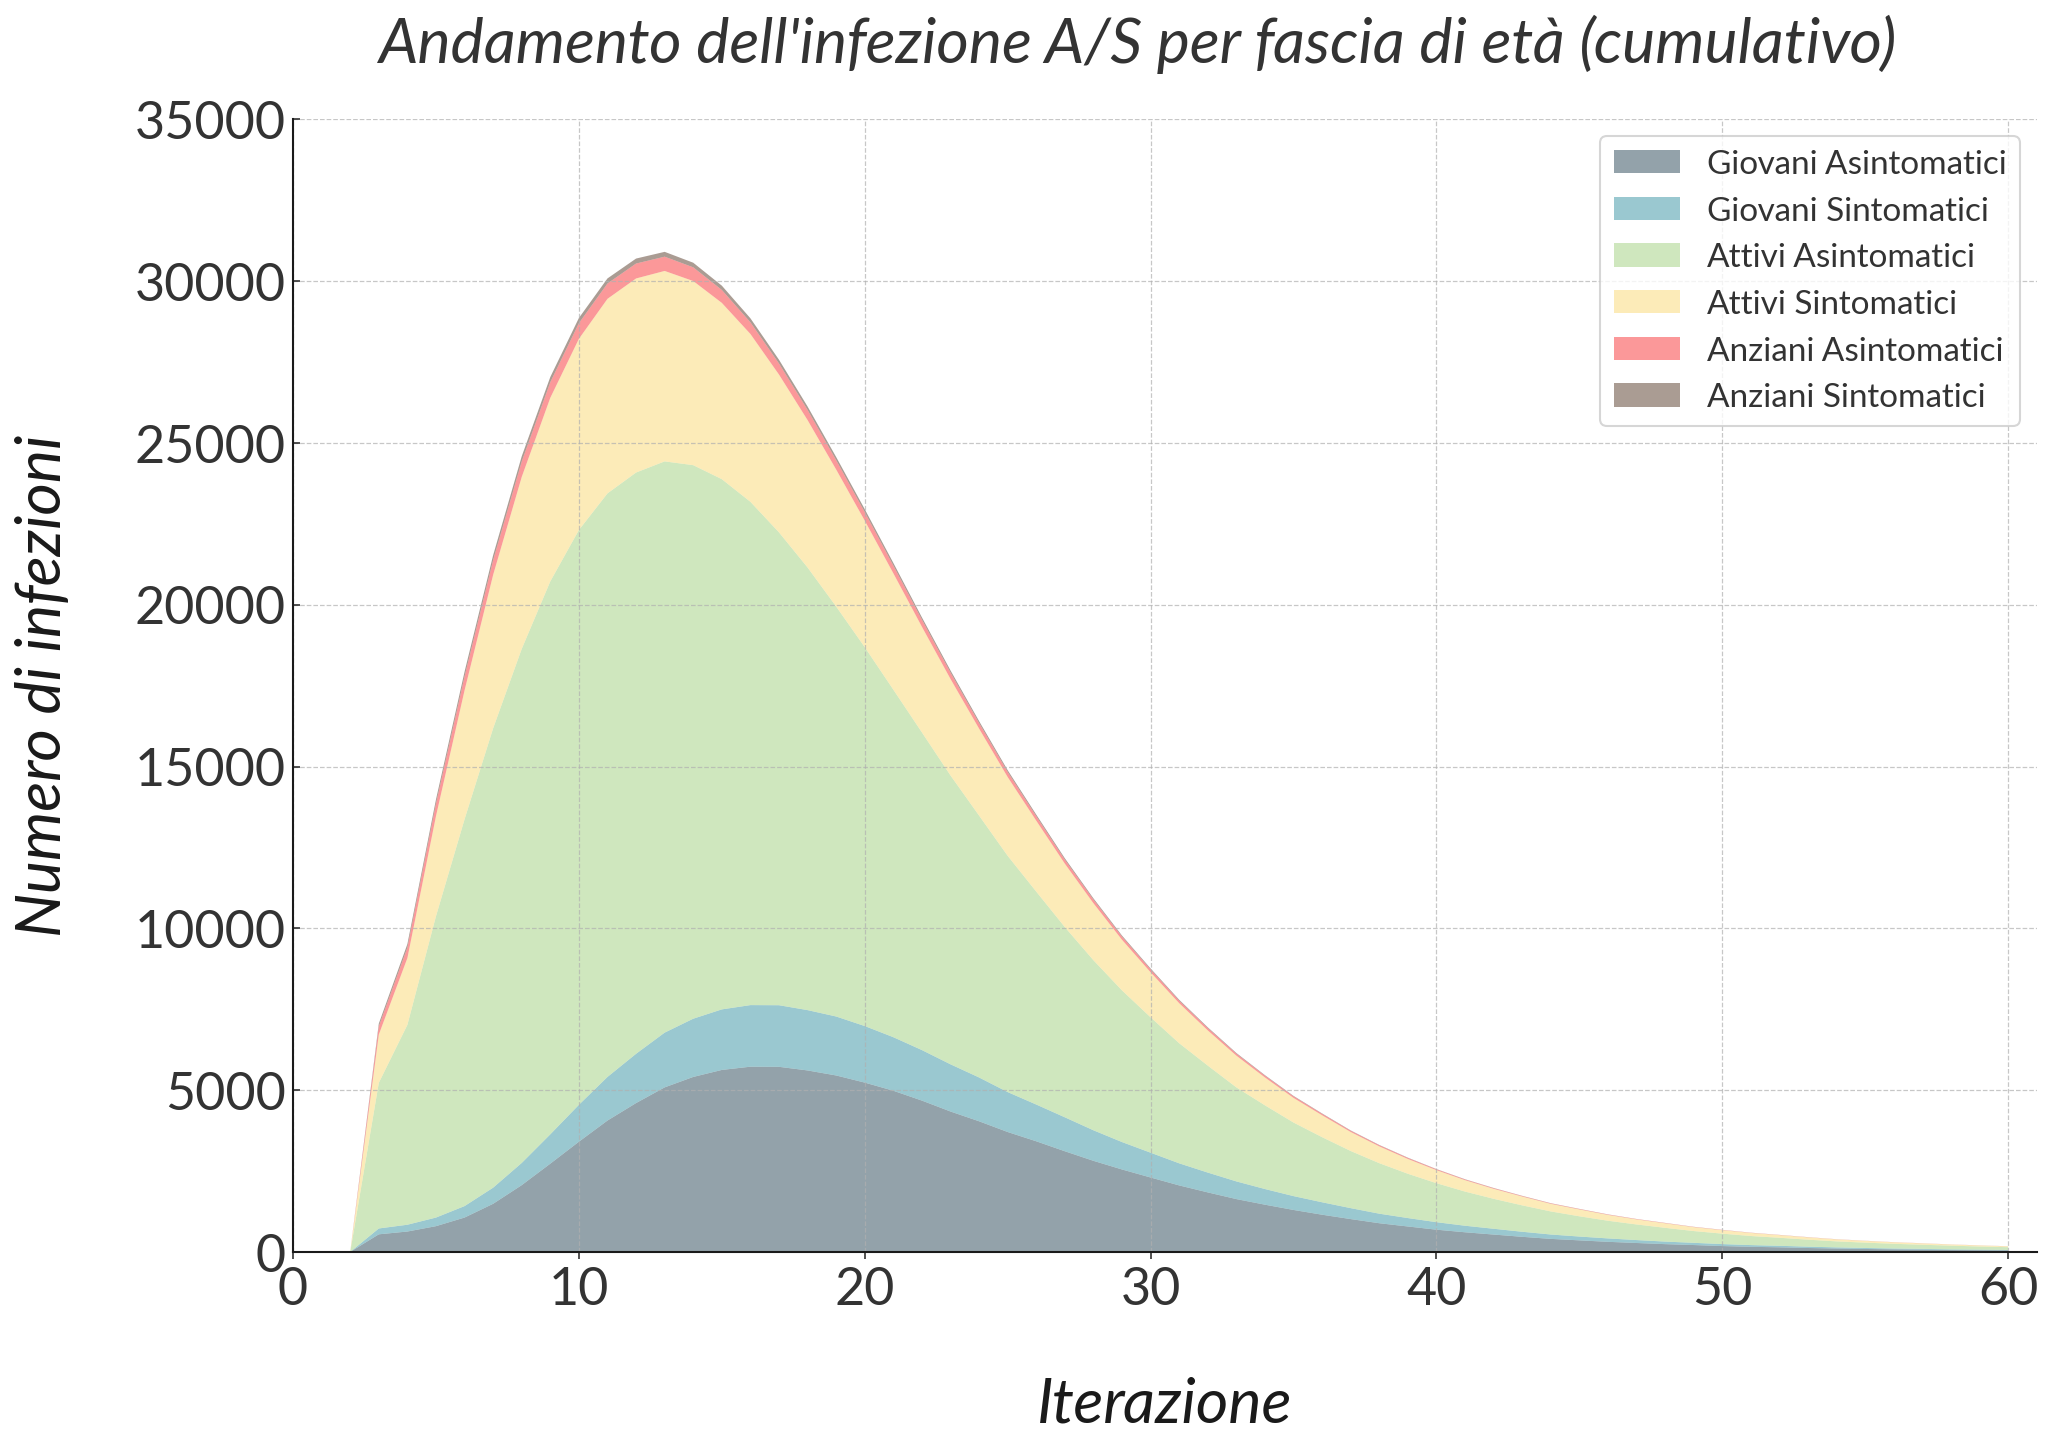

In [857]:
# library

# Your x and y axis
x=range(1,len(simulations[0]['simulation'])+1)
y=[list(giovani_a.values()),list(giovani_s.values()),list(attivi_a.values()),list(attivi_s.values()),list(anziani_a.values()),list(anziani_s.values())]
 
# use a known color palette (see..)
plt.style.use('style.mplstyle')

plt.stackplot(x,y, labels=['Giovani Asintomatici','Giovani Sintomatici','Attivi Asintomatici','Attivi Sintomatici','Anziani Asintomatici','Anziani Sintomatici'], colors=palette, alpha=0.6, linewidth=2 )
plt.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=16)
plt.xlim(0,61)
plt.ylim(0,35000)

#Titles
plt.xlabel("Iterazione", style='italic', labelpad=30)
plt.ylabel("Numero di infezioni", style='italic', labelpad=30)
plt.suptitle("Andamento dell'infezione A/S per fascia di età (cumulativo)", style='italic', y=0.95)
plt.savefig('export_multi_full/noschool_progression_single_cumulative.png')

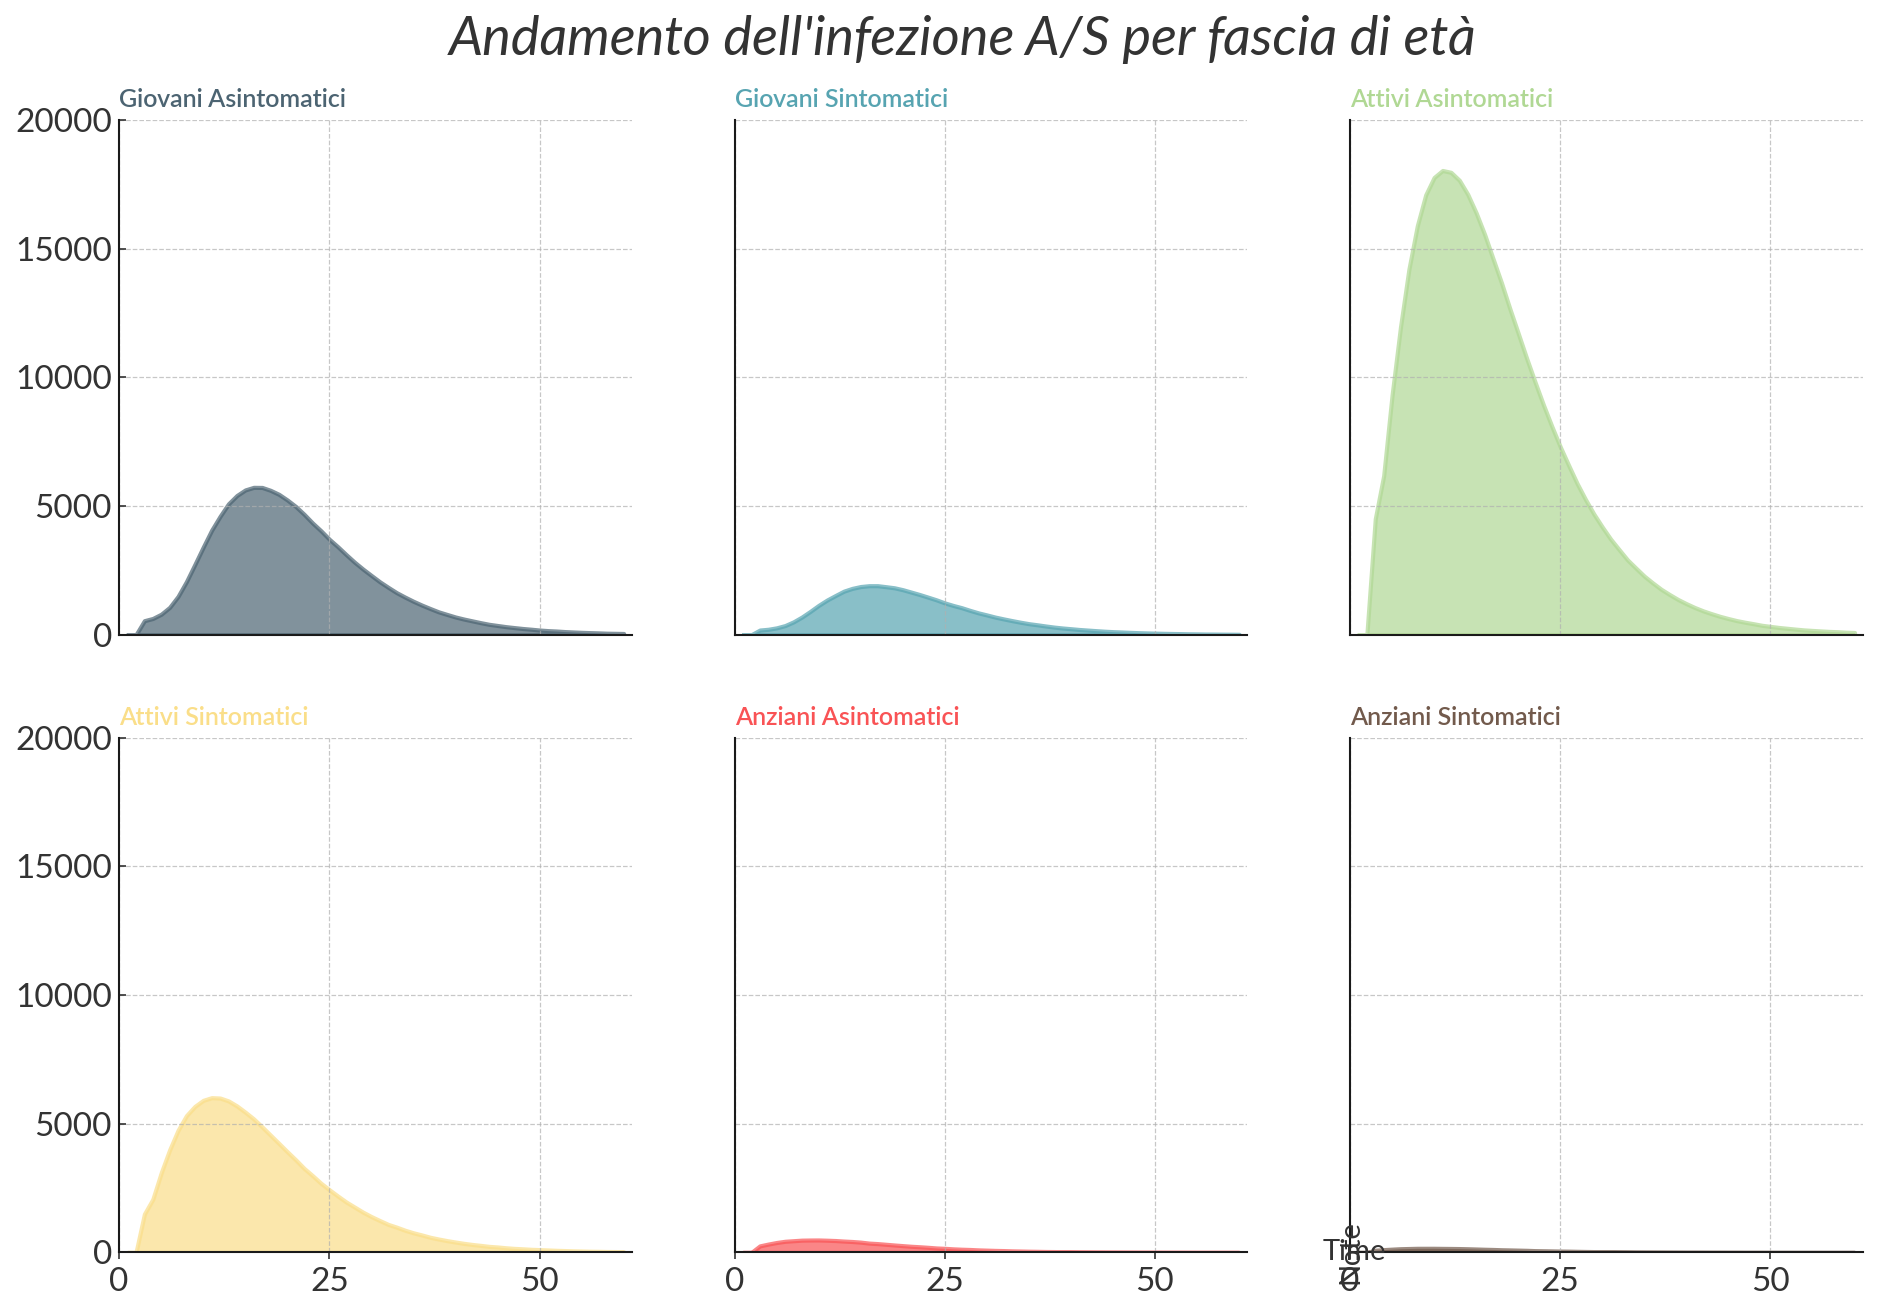

In [860]:
%matplotlib inline
# Initialize the figure
plt.style.use('style.mplstyle')
 
# multiple line plot

num = 0
space = 0
for df in dataframes:
    space += 1
    for column in df.drop('x', axis=1):
        if column != 'CI bottom' and column != 'CI top':
            plt.subplot(2,3, space)
            plt.stackplot(df['x'], df[column], color=palette[num], linewidth=2, alpha=0.7)
            #plt.plot(df['x'], df[column], marker='', color=palette[num], linewidth=1, alpha=0.9, label=column)
            #plt.plot(df['x'], df['CI bottom'], marker='', color=palette[num], linewidth=0, alpha=0)
            #plt.plot(df['x'], df['CI top'], marker='', color=palette[num], linewidth=0, alpha=0)
            #plt.fill_between(df['x'], df['CI bottom'], df['CI top'], color=palette[num], alpha=0.3)
            
            # Same limits for everybody!
            plt.xlim(0,61)
            plt.ylim(0,20000)
            plt.xticks(size = 16)
            plt.yticks(size = 16)
        
            # Not ticks everywhere
            if space in range(4) :
                plt.tick_params(axis='x',labelbottom=False, bottom=False)
            if space not in [1,4] :
                plt.tick_params(axis='y',labelleft=False, left=False)

            # Add title
            plt.title(column, loc='left', fontsize=12, fontweight=600, color=palette[num])
            num += 1
            
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=26, style='italic', y=0.95)

# Axis title
plt.text(0.5, 0.02, 'Time', ha='center', va='center')
plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')

plt.savefig('export_multi_full/noschool_progression_multi.png')

In [ ]:
#Clear last iteration's graph DB
try:
    client.drop_database('tesi')
    print("Database cleared.")
except:
    print("There is no database currently saved.")

#Generate new sezioni database
src.dataset_generators.sezioni_generator.main()

db = client['tesi']
db_sezioni = db['sezioni']

In [645]:
heatmap_r = {}
heatmap_s = {}
for i in list(db_sezioni.find()):
    heatmap_s[i["properties"]["SEZ"]] = []
    heatmap_r[i["properties"]["SEZ"]] = []

for sim in simulations:
    for i in sim['heatmap']['r']:
        heatmap_r[i].append(sim['heatmap']['r'][i])
    for i in sim['heatmap']['s']:
        heatmap_s[i].append(sim['heatmap']['s'][i])

for i in heatmap_s:
    heatmap_s[i] = round(np.mean(heatmap_s[i]))
    if np.isnan(heatmap_s[i]) == True:
        heatmap_s[i] = 0
        
for i in heatmap_r:
    heatmap_r[i] = round(np.mean(heatmap_r[i]))
    if np.isnan(heatmap_r[i]) == True:
        heatmap_r[i] = 0


In [646]:
import json
from shapely.geometry import Point, Polygon

data = json.load(open('Datasets/dataset_completo.geojson'))

for i in data['features']:
    centroid = Polygon(i.get("geometry").get("coordinates")[0]).centroid
    data['features'][data['features'].index(i)]['properties']['lon'] = list(centroid.coords)[0][0]
    data['features'][data['features'].index(i)]['properties']['lat'] = list(centroid.coords)[0][1]
    data['features'][data['features'].index(i)]['properties']['heatmap_s'] = heatmap_s[i['properties']['SEZ']]
    data['features'][data['features'].index(i)]['properties']['heatmap_r'] = heatmap_r[i['properties']['SEZ']]

with open("Datasets/heatmapped.geojson", "w") as outfile:
    json.dump(data, outfile, indent=1)

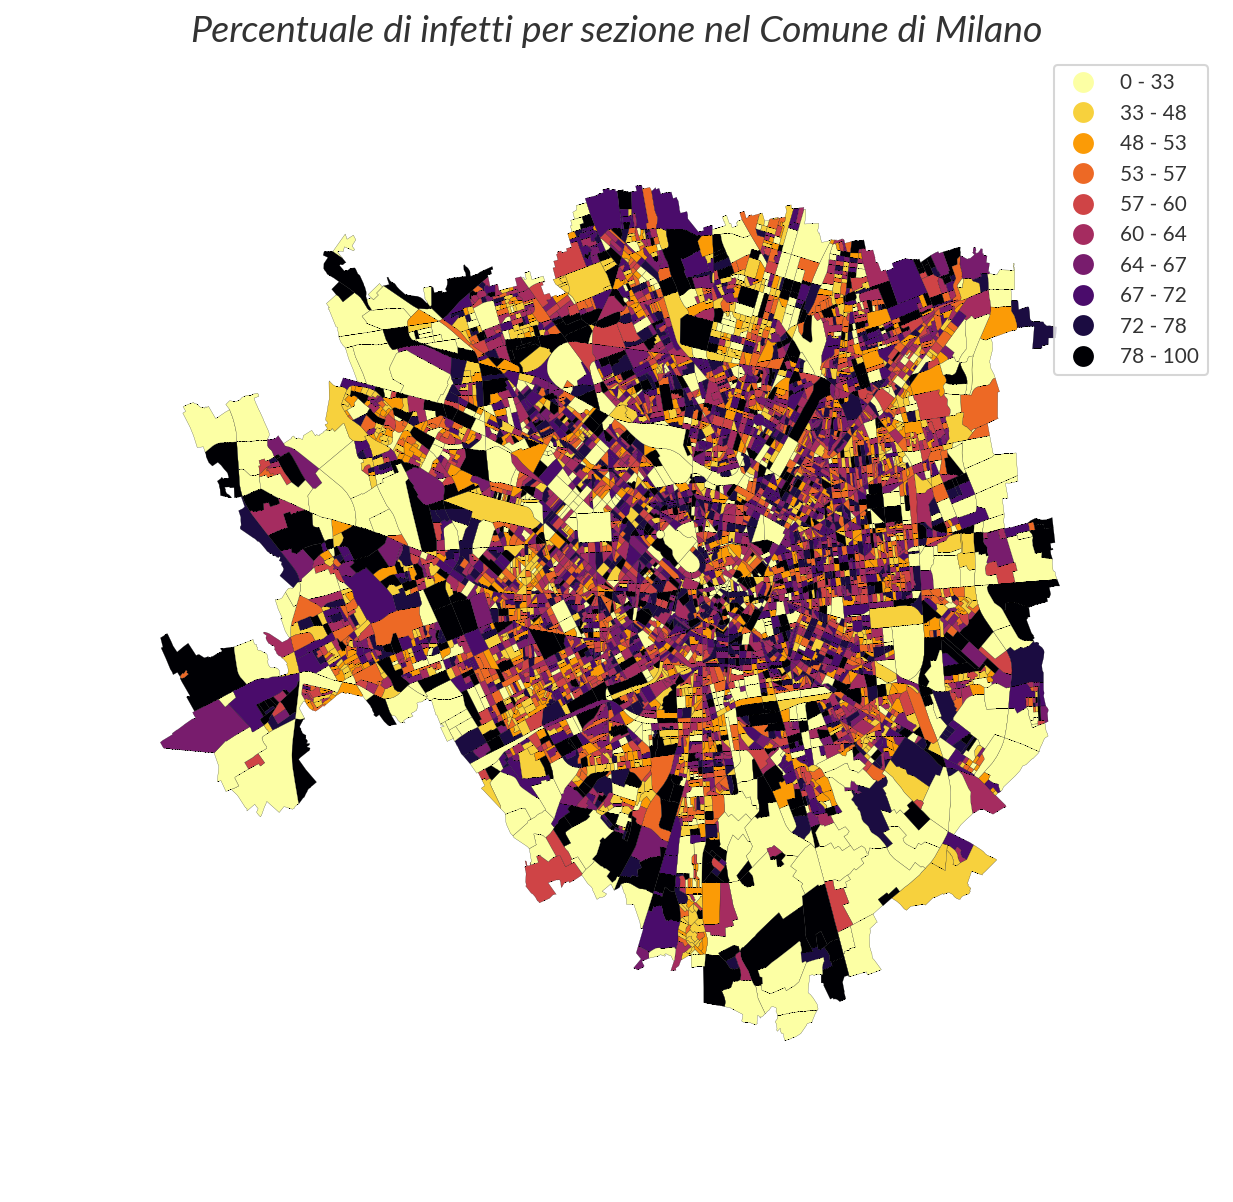

In [723]:
# Import the geopandas and geoplot libraries
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

# Load the json file with county coordinates
geoData = gpd.read_file('Datasets/heatmapped.geojson')

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData['heatmap_r'], k=10)

# Map
gplt.choropleth(geoData,
    hue="heatmap_r", 
    linewidth=.1,
    projection=gcrs.AlbersEqualArea(),
    scheme=scheme, cmap='inferno_r',
    legend=True,
    legend_kwargs = {'bbox_to_anchor':(1, 1), 'loc':1, 'frameon':True, 'fontsize':10},
    edgecolor='black',
    ax=ax
);

ax.set_title('Percentuale di infetti per sezione nel Comune di Milano', fontsize=18, style='italic');
plt.savefig('export_multi_full/heatmap_quantiles.png')

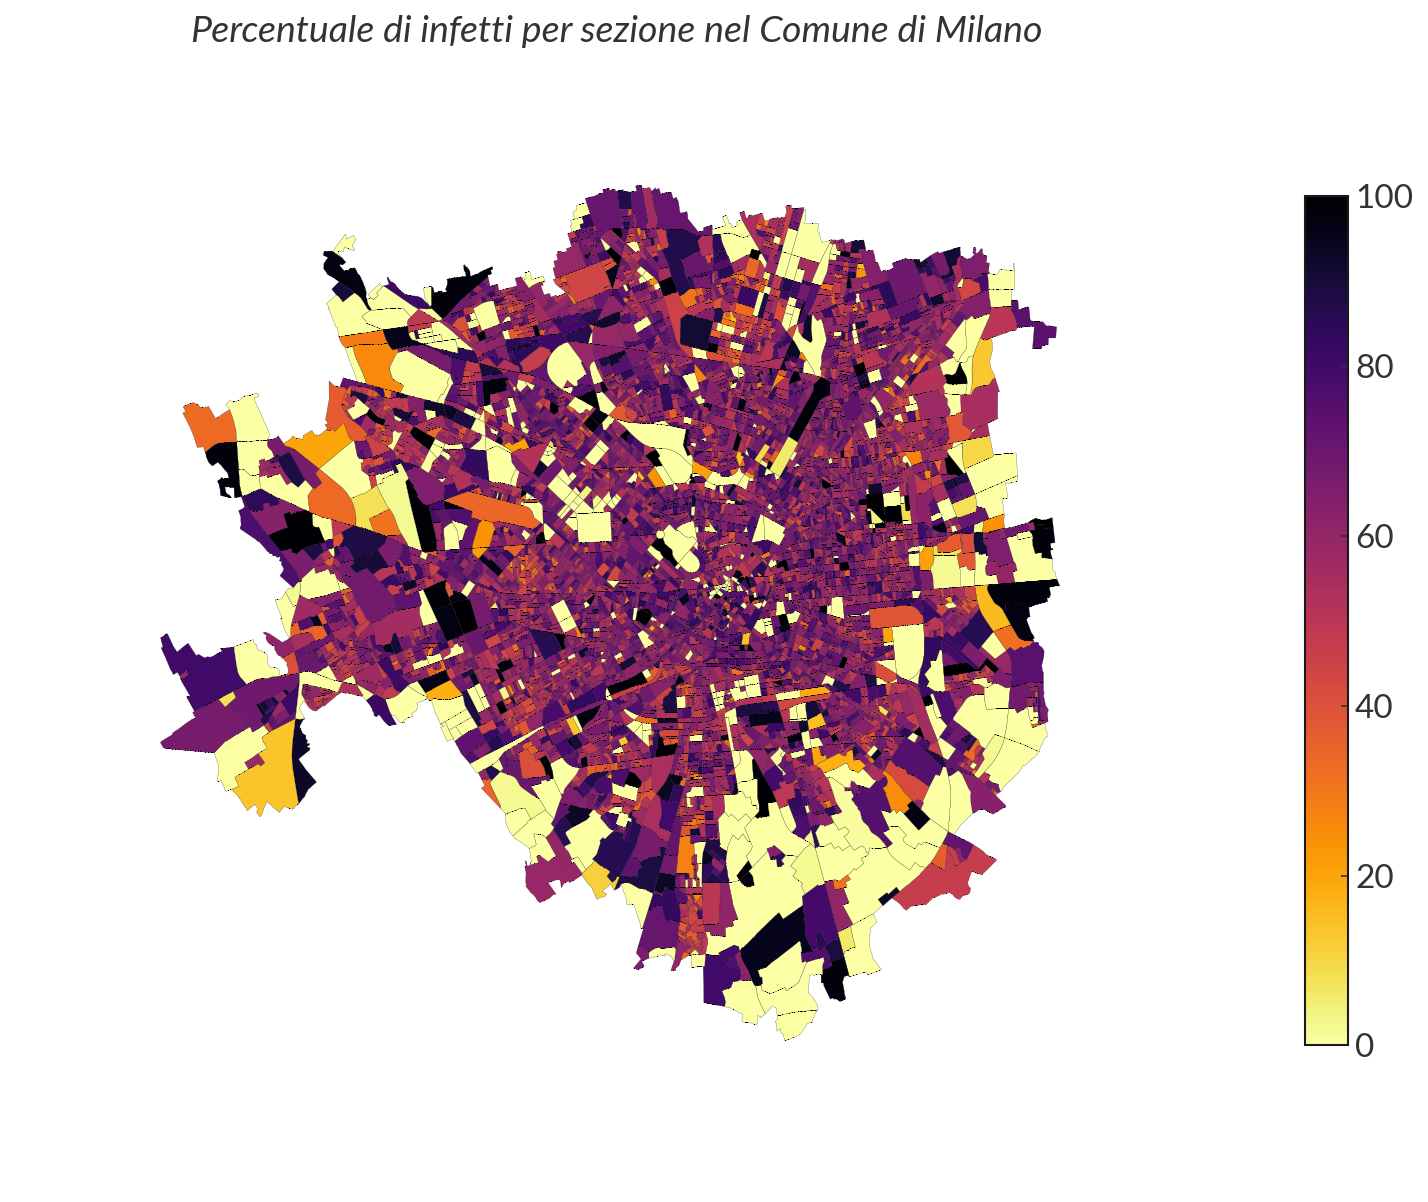

In [724]:
# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})

# Map
gplt.choropleth(geoData,
    hue="heatmap_r", 
    linewidth=.1,
    projection=gcrs.AlbersEqualArea(),
    cmap='inferno_r',
    legend=True,
    legend_kwargs={'shrink': 0.75},
    edgecolor='black',
    ax=ax
);

ax.set_title('Percentuale di infetti per sezione nel Comune di Milano', fontsize=18, style='italic');
plt.savefig('export_multi_full/heatmap.png')

In [725]:
heatmap_r = {}
heatmap_s = {}
for i in list(db_sezioni.find()):
    heatmap_s[i["properties"]["SEZ"]] = []
    heatmap_r[i["properties"]["SEZ"]] = []

for sim in simulations:
    for i in sim['noschool_heatmap']['r']:
        heatmap_r[i].append(sim['noschool_heatmap']['r'][i])
    for i in sim['noschool_heatmap']['s']:
        heatmap_s[i].append(sim['noschool_heatmap']['s'][i])

for i in heatmap_s:
    heatmap_s[i] = round(np.mean(heatmap_s[i]))
    if np.isnan(heatmap_s[i]) == True:
        heatmap_s[i] = 0
        
for i in heatmap_r:
    heatmap_r[i] = round(np.mean(heatmap_r[i]))
    if np.isnan(heatmap_r[i]) == True:
        heatmap_r[i] = 0


In [726]:
import json
from shapely.geometry import Point, Polygon

data = json.load(open('Datasets/dataset_completo.geojson'))

for i in data['features']:
    centroid = Polygon(i.get("geometry").get("coordinates")[0]).centroid
    data['features'][data['features'].index(i)]['properties']['lon'] = list(centroid.coords)[0][0]
    data['features'][data['features'].index(i)]['properties']['lat'] = list(centroid.coords)[0][1]
    data['features'][data['features'].index(i)]['properties']['heatmap_s'] = heatmap_s[i['properties']['SEZ']]
    data['features'][data['features'].index(i)]['properties']['heatmap_r'] = heatmap_r[i['properties']['SEZ']]

with open("Datasets/noschool_heatmapped.geojson", "w") as outfile:
    json.dump(data, outfile, indent=1)

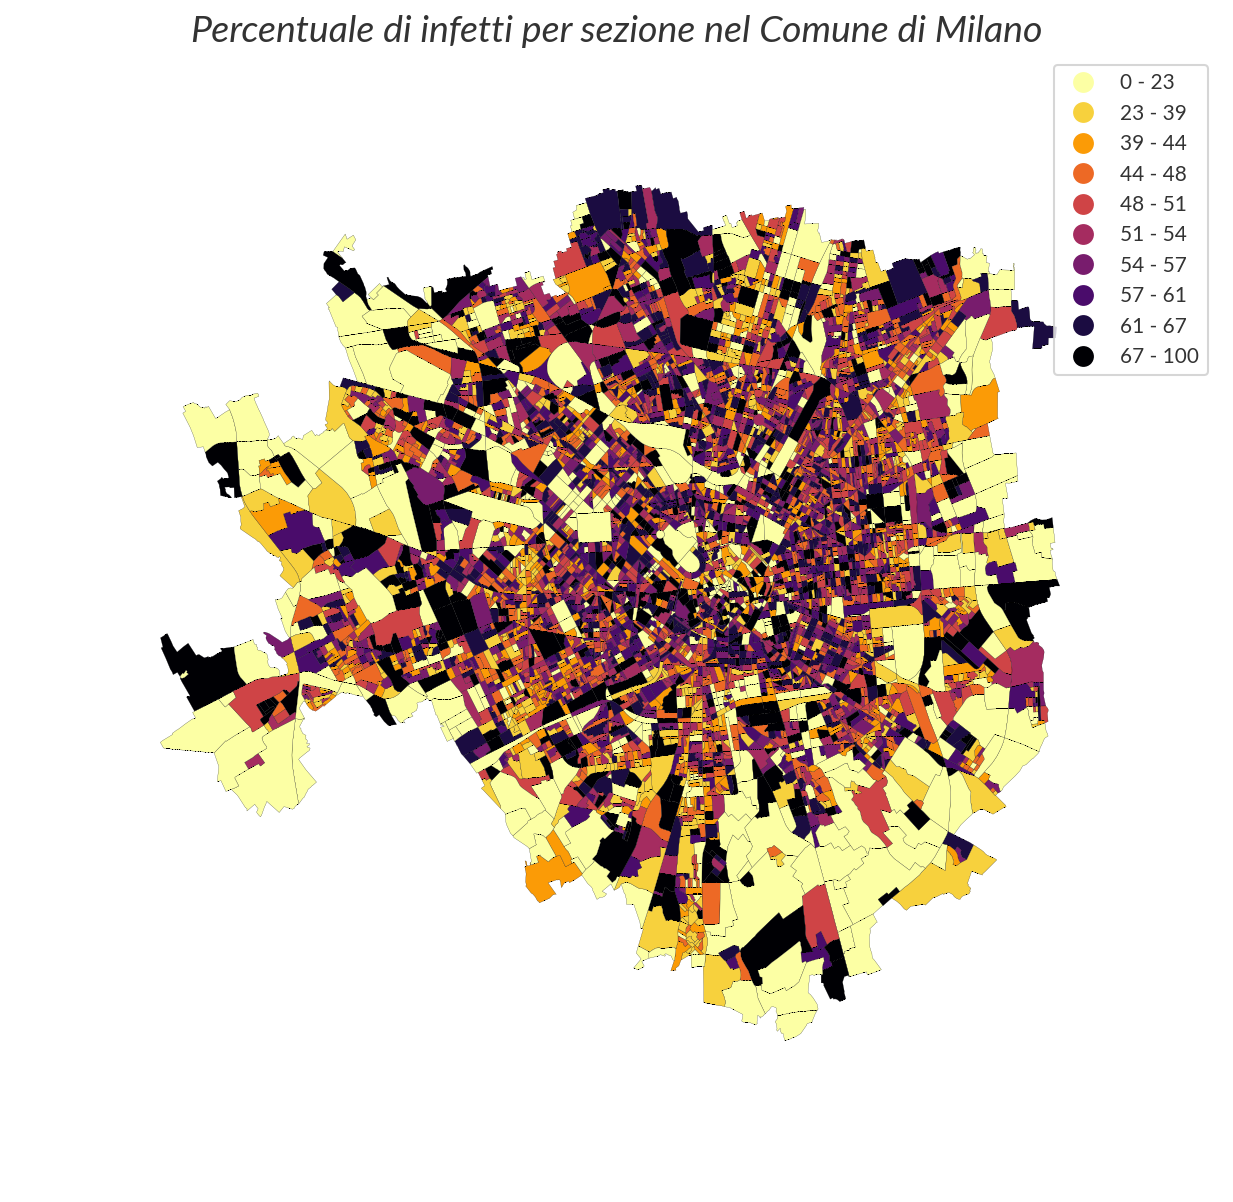

In [729]:
# Import the geopandas and geoplot libraries
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

# Load the json file with county coordinates
geoData = gpd.read_file('Datasets/noschool_heatmapped.geojson')

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(geoData['heatmap_r'], k=10)

# Map
gplt.choropleth(geoData,
    hue="heatmap_r", 
    linewidth=.1,
    projection=gcrs.AlbersEqualArea(),
    scheme=scheme, cmap='inferno_r',
    legend=True,
    legend_kwargs = {'bbox_to_anchor':(1, 1), 'loc':1, 'frameon':True, 'fontsize':10},
    edgecolor='black',
    ax=ax
);

ax.set_title('Percentuale di infetti per sezione nel Comune di Milano', fontsize=18, style='italic');
plt.savefig('export_multi_full/noschool_heatmap_quantiles.png')

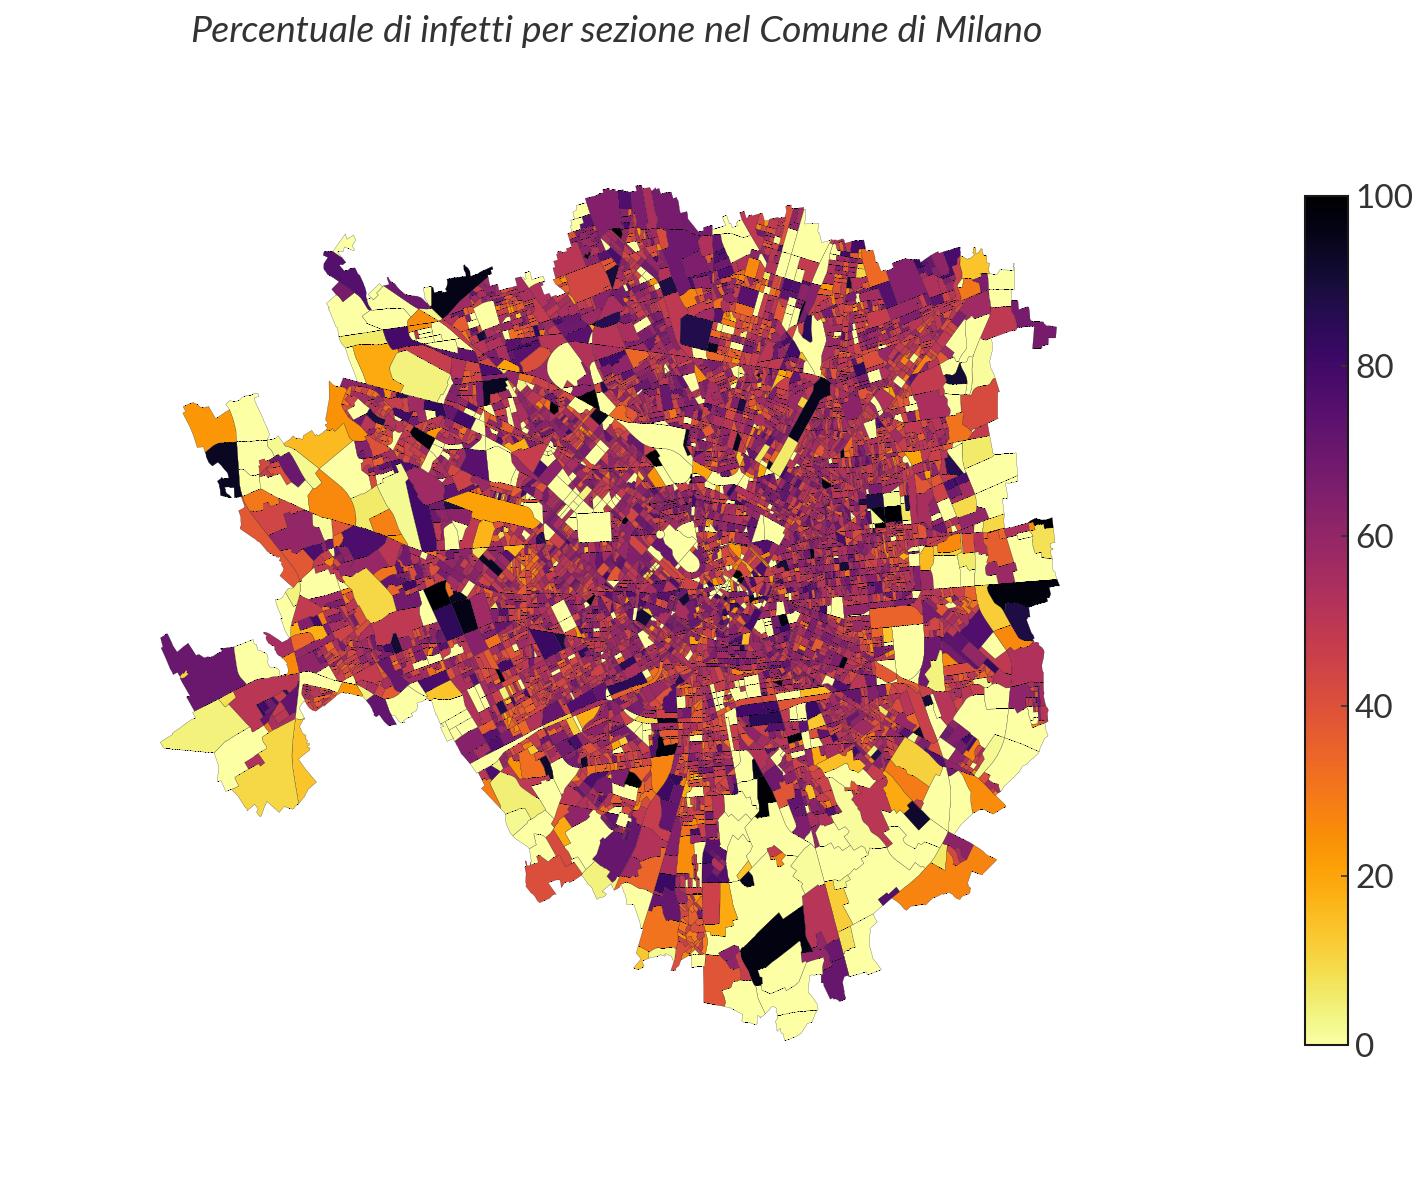

In [730]:
# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})

# Map
gplt.choropleth(geoData,
    hue="heatmap_r", 
    linewidth=.1,
    projection=gcrs.AlbersEqualArea(),
    cmap='inferno_r',
    legend=True,
    legend_kwargs={'shrink': 0.75},
    edgecolor='black',
    ax=ax
);

ax.set_title('Percentuale di infetti per sezione nel Comune di Milano', fontsize=18, style='italic');
plt.savefig('export_multi_full/noschool_heatmap.png')

In [814]:
#Scrap cells: random stuff-checking code goes here and below
print('Nodes outside of G0')
print(simulations[0]['tot_agedistrib'])
tot = 0
for i in simulations[0]['tot_agedistrib']:
    tot += simulations[0]['tot_agedistrib'][i][0]
print(tot)
print()
print('Total nodes')
print(simulations[0]['G0_agedistrib'])
tot = 0
for i in simulations[0]['G0_agedistrib']:
    tot += simulations[0]['G0_agedistrib'][i][0]
print(tot)

print()
mean_giovani = np.mean([i['G0_agedistrib']['giovani'] for i in simulations])
mean_attivi = np.mean([i['G0_agedistrib']['attivi'] for i in simulations])
mean_anziani = np.mean([i['G0_agedistrib']['anziani'] for i in simulations])

print(mean_giovani)
print(mean_attivi)
print(mean_anziani)



Nodes outside of G0
{'giovani': [9327], 'attivi': [147337], 'anziani': [292118]}
448782

Total nodes
{'giovani': [203455], 'attivi': [720641], 'anziani': [305646]}
1229742

203963.76
720597.04
305481.94
